In [2]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scanpy as sc
from bbknn import bbknn
import scanorama as scr
import pandas as pd
import scrublet as crub


sc.settings.verbosity = 3            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=100)

scanpy==1.6.0 anndata==0.7.4 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.7.0


# P38_dr

## Read in data, basic pre-processing

In [2]:

oneA = sc.read_10x_mtx(base_path + 'P38_dr_1_a/filtered_feature_bc_matrix', var_names='gene_symbols', cache=True)
oneB = sc.read_10x_mtx(base_path + 'P38_dr_1_b/filtered_feature_bc_matrix', var_names='gene_symbols', cache=True)
twoA = sc.read_10x_mtx(base_path + 'P38_dr_2_a/filtered_feature_bc_matrix', var_names='gene_symbols', cache=True)
twoB = sc.read_10x_mtx(base_path + 'P38_dr_2_b/filtered_feature_bc_matrix', var_names='gene_symbols', cache=True)

... reading from cache file cache/Volumes-GoogleDrive-My Drive-mouse visual cortex-P38_dr_1_a-filtered_feature_bc_matrix-matrix.h5ad


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


... reading from cache file cache/Volumes-GoogleDrive-My Drive-mouse visual cortex-P38_dr_1_b-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/Volumes-GoogleDrive-My Drive-mouse visual cortex-P38_dr_2_a-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/Volumes-GoogleDrive-My Drive-mouse visual cortex-P38_dr_2_b-filtered_feature_bc_matrix-matrix.h5ad


In [3]:
P28_dr = oneA.concatenate(oneB, twoA, twoB, batch_categories=['P38_dr_1a', 'P38_dr_1b', 'P38_dr_2a', 'P38_dr_2b'])

In [4]:
P28_dr

AnnData object with n_obs × n_vars = 36373 × 53801
    obs: 'batch'
    var: 'gene_ids', 'feature_types'

In [5]:
sc.pp.filter_cells(P28_dr, min_genes=700) #cell must have 700 non-zero-count features to stay
sc.pp.filter_genes(P28_dr, min_cells=8) #gene must be in 8 cells to stay

filtered out 3873 cells that have less than 700 genes expressed
filtered out 28048 genes that are detected in less than 8 cells


In [6]:
P28_dr

AnnData object with n_obs × n_vars = 32500 × 25753
    obs: 'batch', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [7]:
mito_genes = P28_dr.var_names.str.startswith('mt-') #boolean array denoting if a gene is mito

# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

# add each cell's fraction mito accounts as an obs annotation
P28_dr.obs['percent_mito'] = np.sum(P28_dr[:, mito_genes].X, axis=1).A1 / np.sum(P28_dr.X, axis=1).A1

# add the total counts per cell as observations-annotation to P28_dr
P28_dr.obs['n_counts'] = P28_dr.X.sum(axis=1).A1

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical


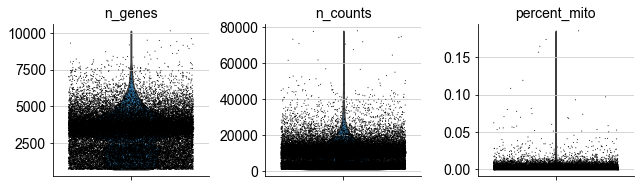

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


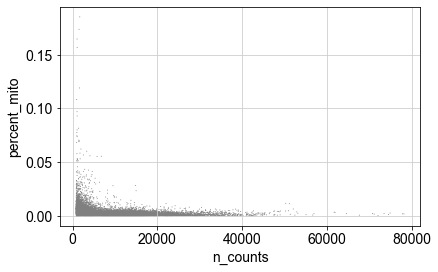

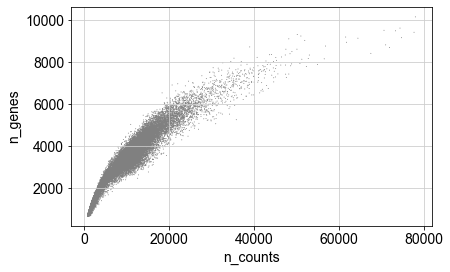

In [8]:
sc.pl.violin(P28_dr, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(P28_dr, x='n_counts', y='percent_mito')
sc.pl.scatter(P28_dr, x='n_counts', y='n_genes')

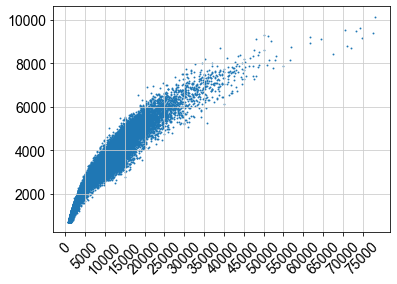

In [9]:
plt.scatter(P28_dr.obs['n_counts'], P28_dr.obs['n_genes'], s=0.8)
plt.xticks(np.linspace(0,75000, 16), rotation='45')
plt.show()

In [10]:
P28_dr = P28_dr[P28_dr.obs.percent_mito < 0.01, :]
P28_dr = P28_dr[P28_dr.obs['n_genes'] < 8000, :]
P28_dr = P28_dr[P28_dr.obs['n_counts'] < 45000, :]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [11]:
P28_dr

View of AnnData object with n_obs × n_vars = 31662 × 25753
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


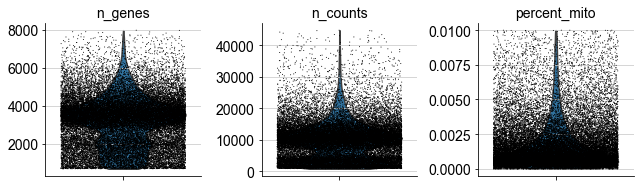

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


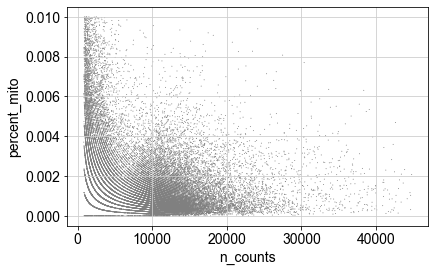

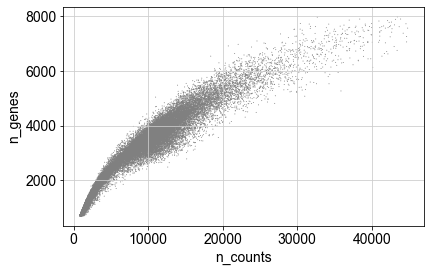

In [12]:
sc.pl.violin(P28_dr, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(P28_dr, x='n_counts', y='percent_mito')
sc.pl.scatter(P28_dr, x='n_counts', y='n_genes')

## Doublet detection

Using the filtering info obtained by joint analysis, the object for which has now been deleted.

In [13]:
del P28_dr

filtered out 457 cells that have less than 700 genes expressed


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 31974 genes that are detected in less than 8 cells


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.19
Detected doublet rate = 6.5%
Estimated detectable doublet fraction = 58.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 11.2%
Elapsed time: 12.7 seconds


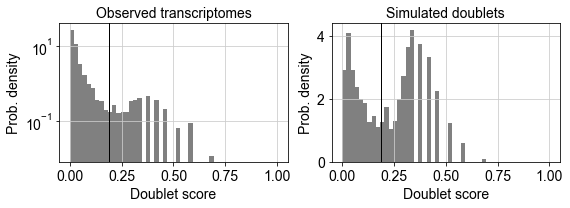

filtered out 3022 cells that have less than 700 genes expressed


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 31926 genes that are detected in less than 8 cells


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 42.9%
Elapsed time: 13.1 seconds


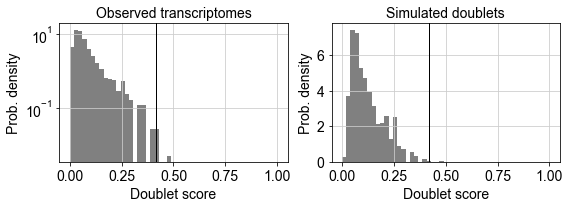

filtered out 202 cells that have less than 700 genes expressed


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 32328 genes that are detected in less than 8 cells


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.21
Detected doublet rate = 4.5%
Estimated detectable doublet fraction = 53.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 8.5%
Elapsed time: 10.6 seconds


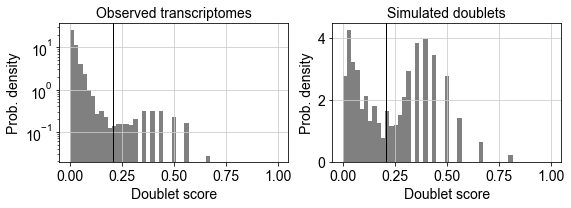

filtered out 192 cells that have less than 700 genes expressed


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 32478 genes that are detected in less than 8 cells


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


Trying to set attribute `.obs` of view, copying.


Automatically set threshold at doublet score = 0.21
Detected doublet rate = 4.5%
Estimated detectable doublet fraction = 53.9%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 8.3%
Elapsed time: 10.3 seconds


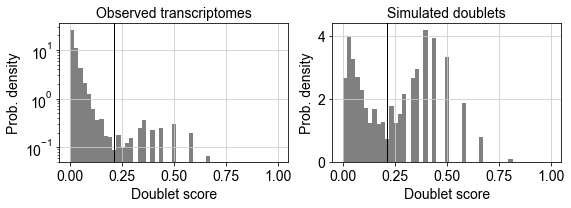

In [14]:
samples = [oneA, oneB, twoA, twoB]
for i in range(len(samples)):
    sc.pp.filter_cells(samples[i], min_genes=700) #cell must have 700 non-zero-count features to stay
    sc.pp.filter_genes(samples[i], min_cells=8) #gene must be in 8 cells to stay

    mito_genes = samples[i].var_names.str.startswith('mt-') #boolean array denoting if a gene is mito

    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

    # add each cell's fraction mito accounts as an obs annotation
    samples[i].obs['percent_mito'] = np.sum(samples[i][:, mito_genes].X, axis=1).A1 / np.sum(samples[i].X, axis=1).A1

    # add the total counts per cell as observations-annotation to samples[i]
    samples[i].obs['n_counts'] = samples[i].X.sum(axis=1).A1

    samples[i] = samples[i][samples[i].obs.percent_mito < 0.01, :]
    samples[i] = samples[i][samples[i].obs['n_genes'] < 8000, :]
    samples[i] = samples[i][samples[i].obs['n_counts'] < 45000, :]
    

    counts_matrix = samples[i].X

    scrub = crub.Scrublet(counts_matrix, expected_doublet_rate=0.06)

    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_cells=8, 
                                                              min_gene_variability_pctl=85, 
                                                              n_prin_comps=40)

    #scrub.plot_histogram()
    #plt.show()
    samples[i].obs['Doublet'] = scrub.predicted_doublets_
    samples[i].obs['Doublet Score'] = scrub.doublet_scores_obs_
    scrub.plot_histogram()
    plt.show()
    
P28_dr = samples[0].concatenate(samples[1], samples[2], samples[3], batch_categories=['P38_dr_1a', 'P38_dr_1b', 'P38_dr_2a', 'P38_dr_2b'])

In [15]:
P28_dr[P28_dr.obs.Doublet==True,:].shape[0]*100/P28_dr.shape[0]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


3.7398528064689347

In [16]:
P28_dr[P28_dr.obs.Doublet==True,:].shape[0]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


1184

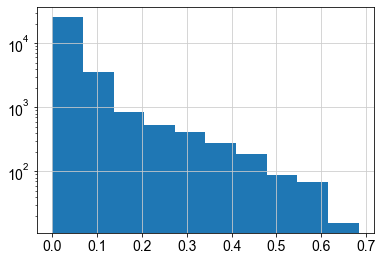

In [17]:
plt.hist(P28_dr.obs['Doublet Score'], log='y')
plt.show()

## Pre-processing and clustering workflow

In [18]:
sc.pp.normalize_per_cell(P28_dr, counts_per_cell_after=1e4)
sc.pp.log1p(P28_dr)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [19]:
P28_dr.raw = P28_dr #store pre-scale counts

In [21]:
sc.pp.highly_variable_genes(P28_dr, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs

sc.pp.scale(P28_dr, max_value=10) #scale

sc.tl.pca(P28_dr, svd_solver='arpack') #run PCA

#sc.pp.neighbors(P28_dr, n_neighbors=25, n_pcs=40) #choose 25 standard for now
bbknn(P28_dr, batch_key='batch',neighbors_within_batch =6 ) #6*4 ~ 25, which is consistent for other ages

sc.tl.leiden(P28_dr)
sc.tl.umap(P28_dr)

extracting highly variable genes
    finished (0:00:10)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    with n_comps=50
    finished (0:00:10)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:07)
running Leiden clustering


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:31)


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden']"]`


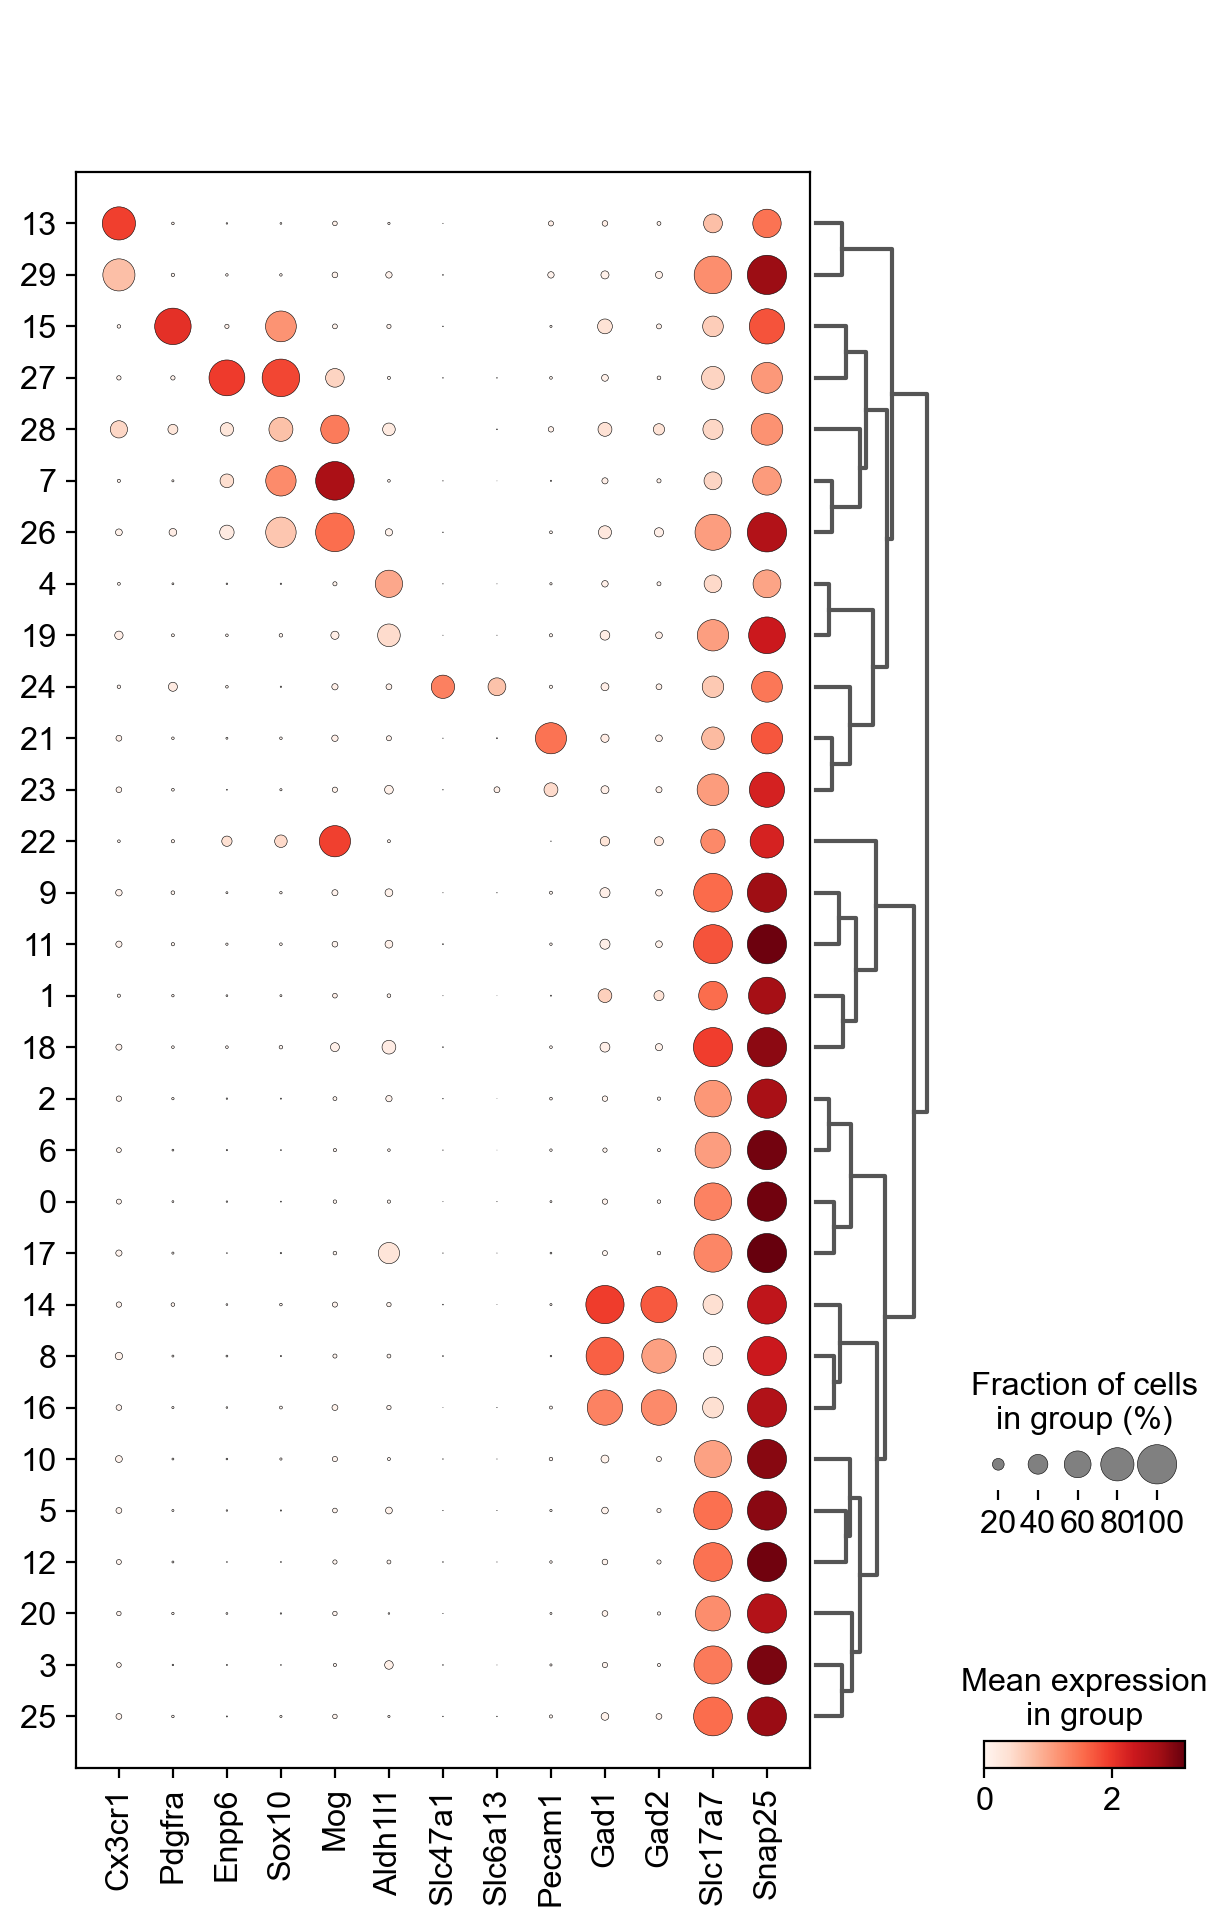

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<AxesSubplot:title={'center':'batch'}, xlabel='UMAP1', ylabel='UMAP2'>

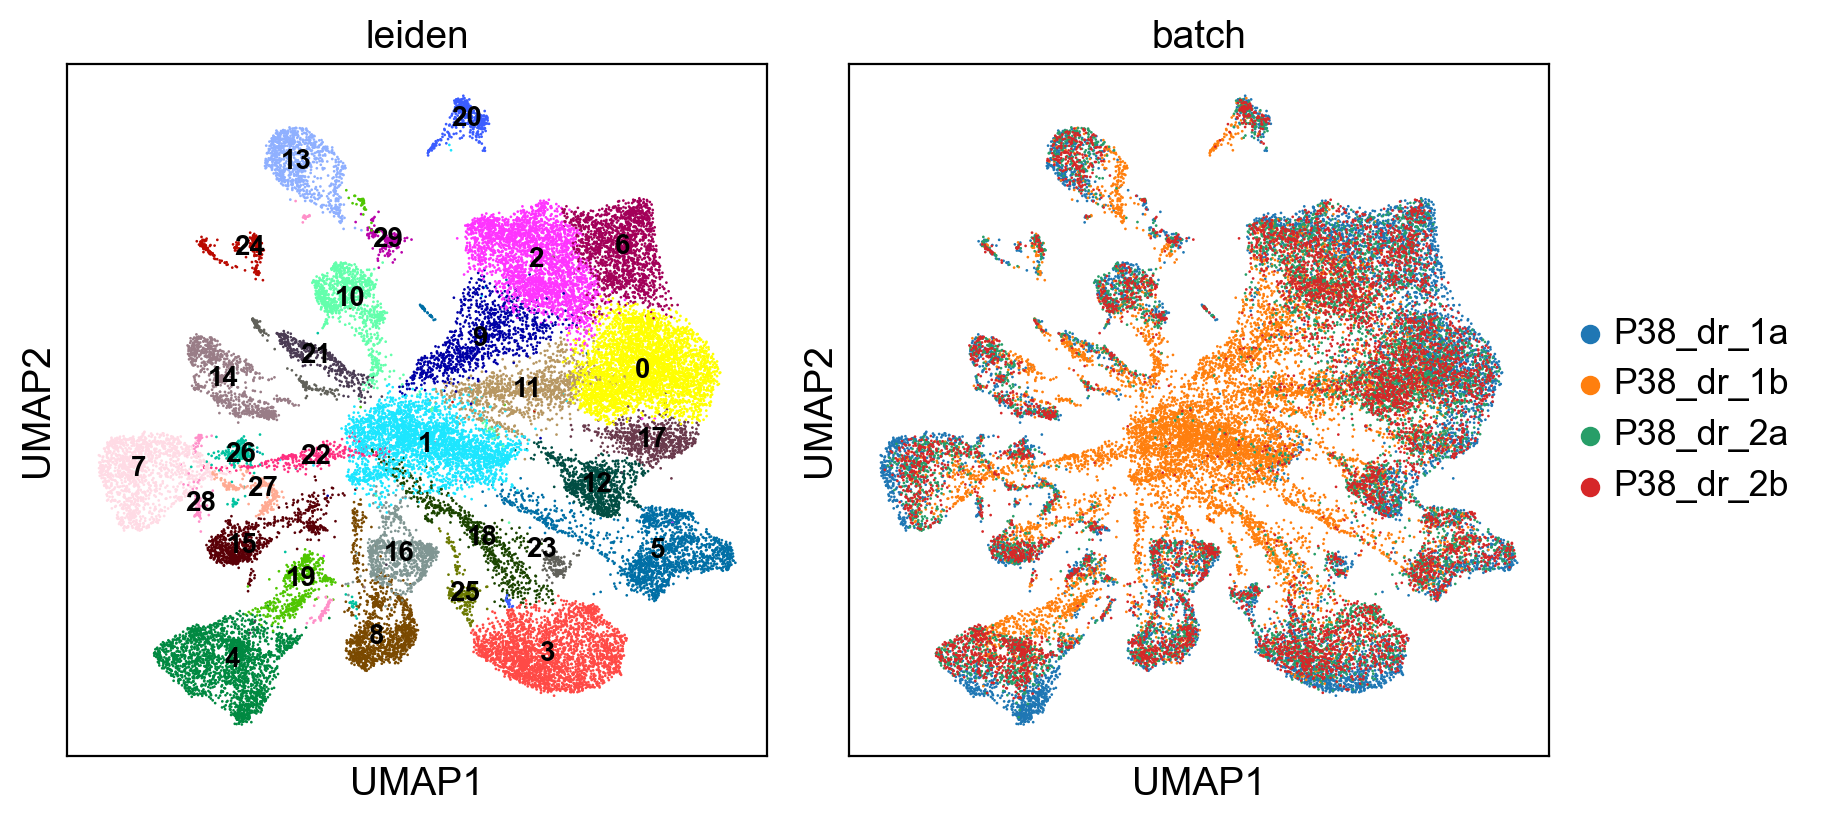

In [39]:
#w/o bbknn
leiden_markers = ['Cx3cr1', 'Pdgfra', 'Enpp6', 'Sox10', 'Mog', 'Aldh1l1', 'Slc47a1', 'Slc6a13', 'Pecam1', 'Gad1', 'Gad2', 'Slc17a7', 'Snap25']

sc.pl.dotplot(P28_dr, leiden_markers, groupby='leiden', dendrogram=True)


fig, axs = plt.subplots(1, 2, figsize = (9,4), constrained_layout=True)

sc.pl.umap(P28_dr, color=['leiden'], legend_fontsize='10', legend_loc='on data', ax=axs[0], show=False)
sc.pl.umap(P28_dr, color=['batch'], ax=axs[1], show=False)

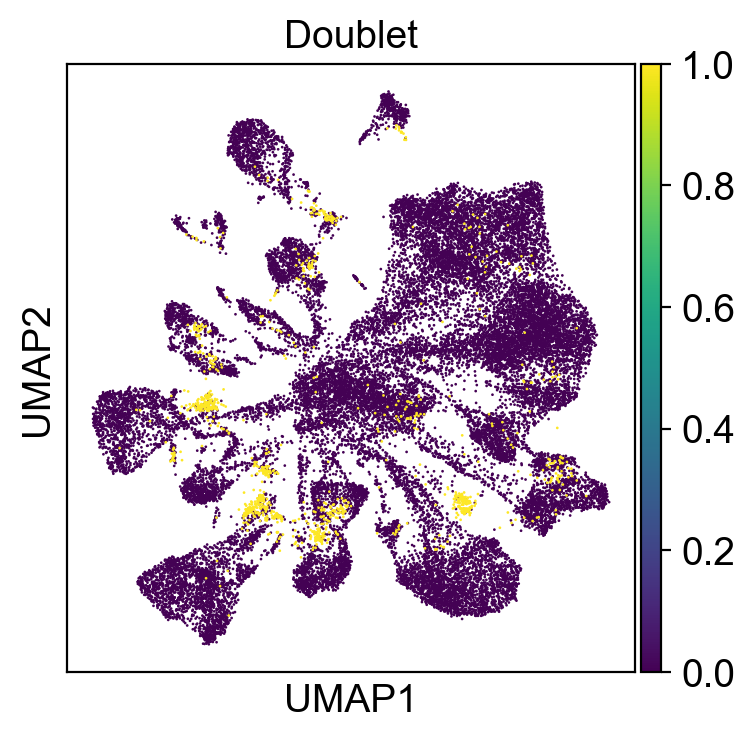

In [40]:
sc.pl.umap(P28_dr, color=['Doublet'])

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


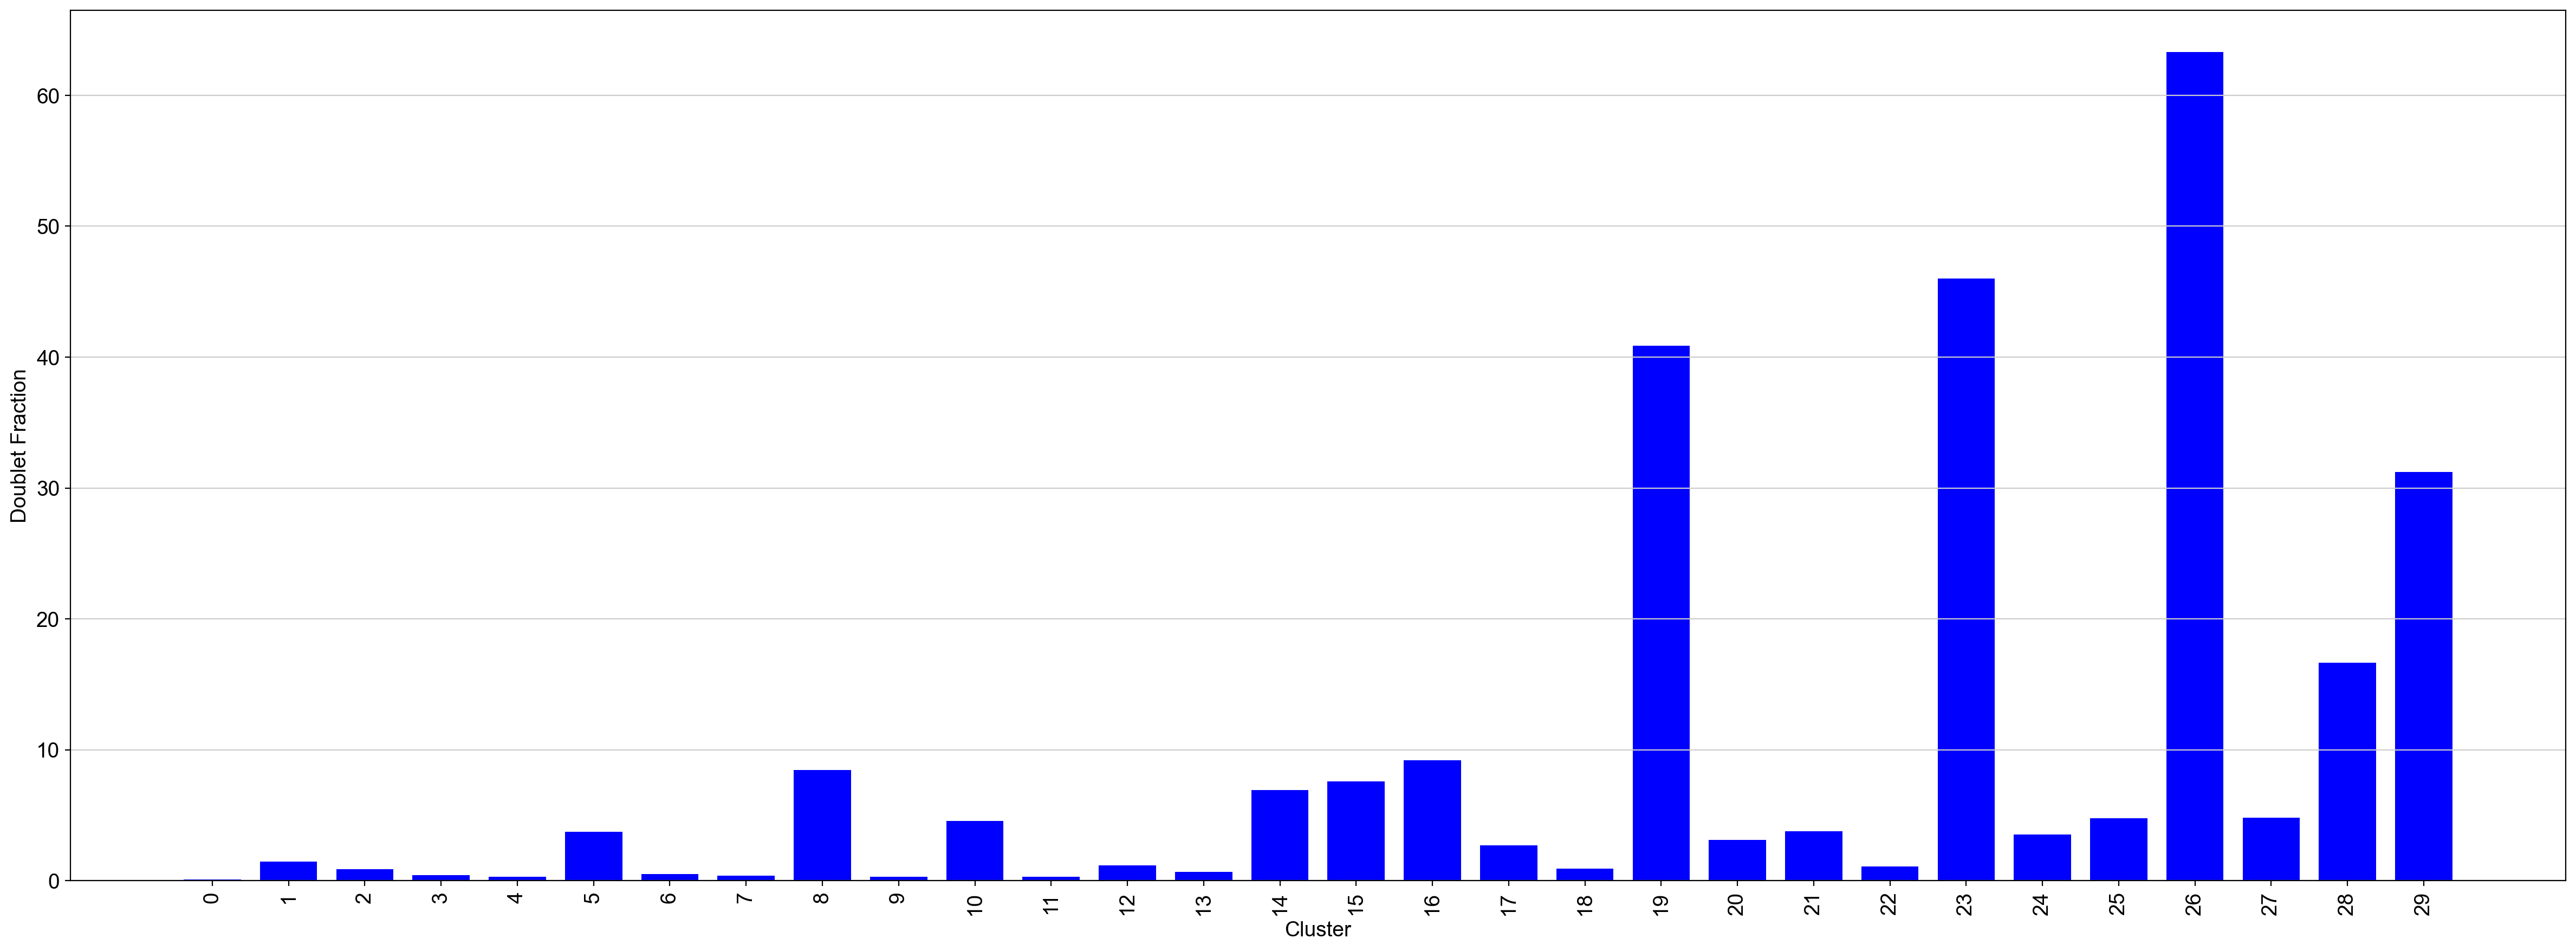

In [41]:
doublet_perc = []
x_pos = list(P28_dr.obs.leiden.values.categories)
for i in x_pos:
    current_clust = P28_dr[P28_dr.obs.leiden==i, :]
    doublet_perc.append((current_clust[current_clust.obs.Doublet,:].shape[0]/current_clust.shape[0])*100)

fig, ax = plt.subplots(figsize=(24,9))
ax.bar(x_pos, doublet_perc, color='blue', width=0.75)
ax.set_ylabel('Doublet Fraction')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos, rotation='90')
#ax.set_title('Percentage of doublets')
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.set_xlabel('Cluster')
# Save the figure and show
plt.tight_layout()

Text(0, 0.5, 'Percentage of cells')

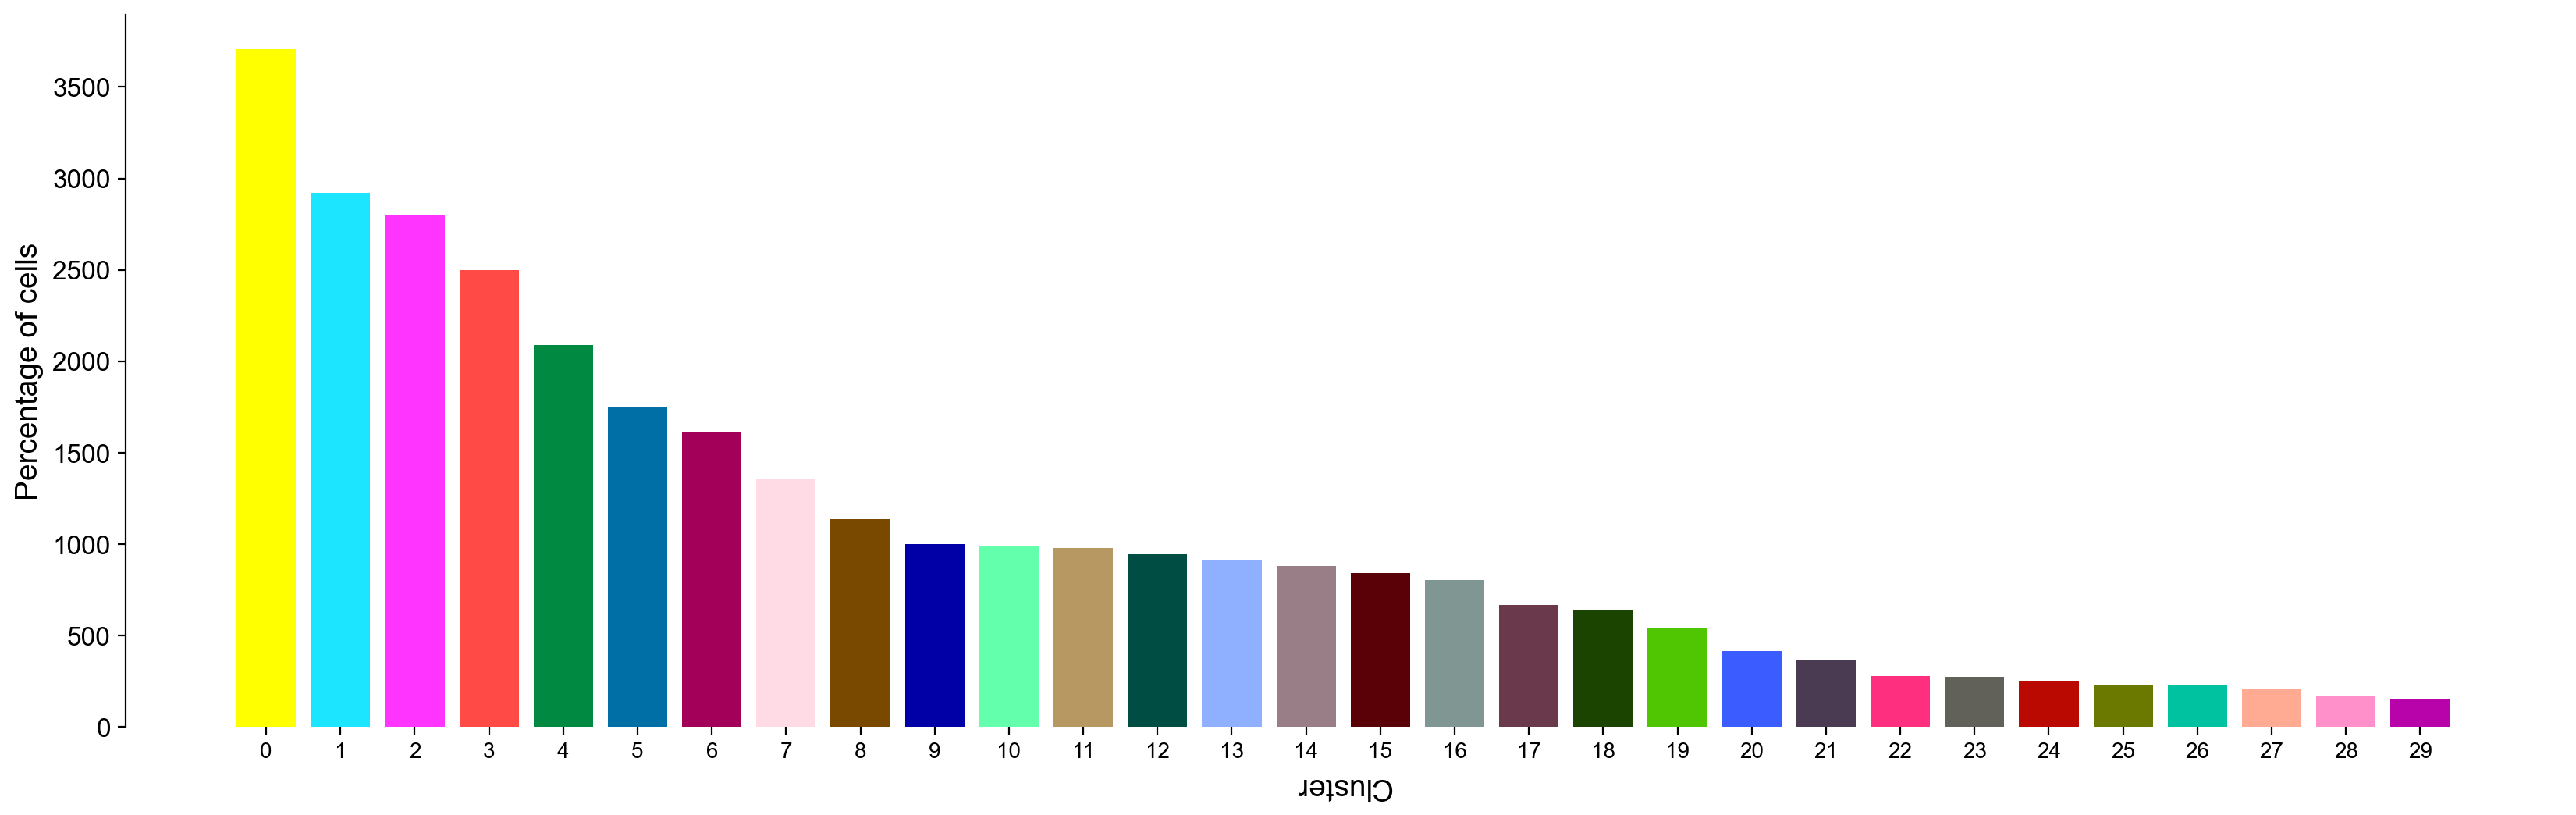

In [42]:
#code
x_pos = list(P28_dr.obs.leiden.values.categories)

total_cells = P28_dr.shape[0]
cell_fraction = []
cell_count = []

for i in x_pos:
    #cell_fraction.append(P28_dr[P28_dr.obs.leiden==i, :].shape[0]*100/total_cells)
    cell_fraction.append(P28_dr[P28_dr.obs.leiden==i, :].shape[0])
    cell_count.append(P28_dr[P28_dr.obs.leiden==i, :].shape[0])



fig, ax = plt.subplots(figsize=(20,6))

right_side = ax.spines["right"]
top = ax.spines["top"]
bottom = ax.spines["bottom"]

right_side.set_visible(False)
top.set_visible(False)
bottom.set_visible(False)


plt.bar(x_pos, cell_fraction, color = P28_dr.uns['leiden_colors'])
plt.grid(False)
plt.xticks(rotation='0', fontsize='10')
plt.yticks(fontsize ='12')

plt.xlabel('Cluster', rotation='180')
plt.ylabel('Percentage of cells')

#axs.set_yticks([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000])


Clearly, bbknn cleans up the clusters by tightening specificity of markers.

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden']"]`


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


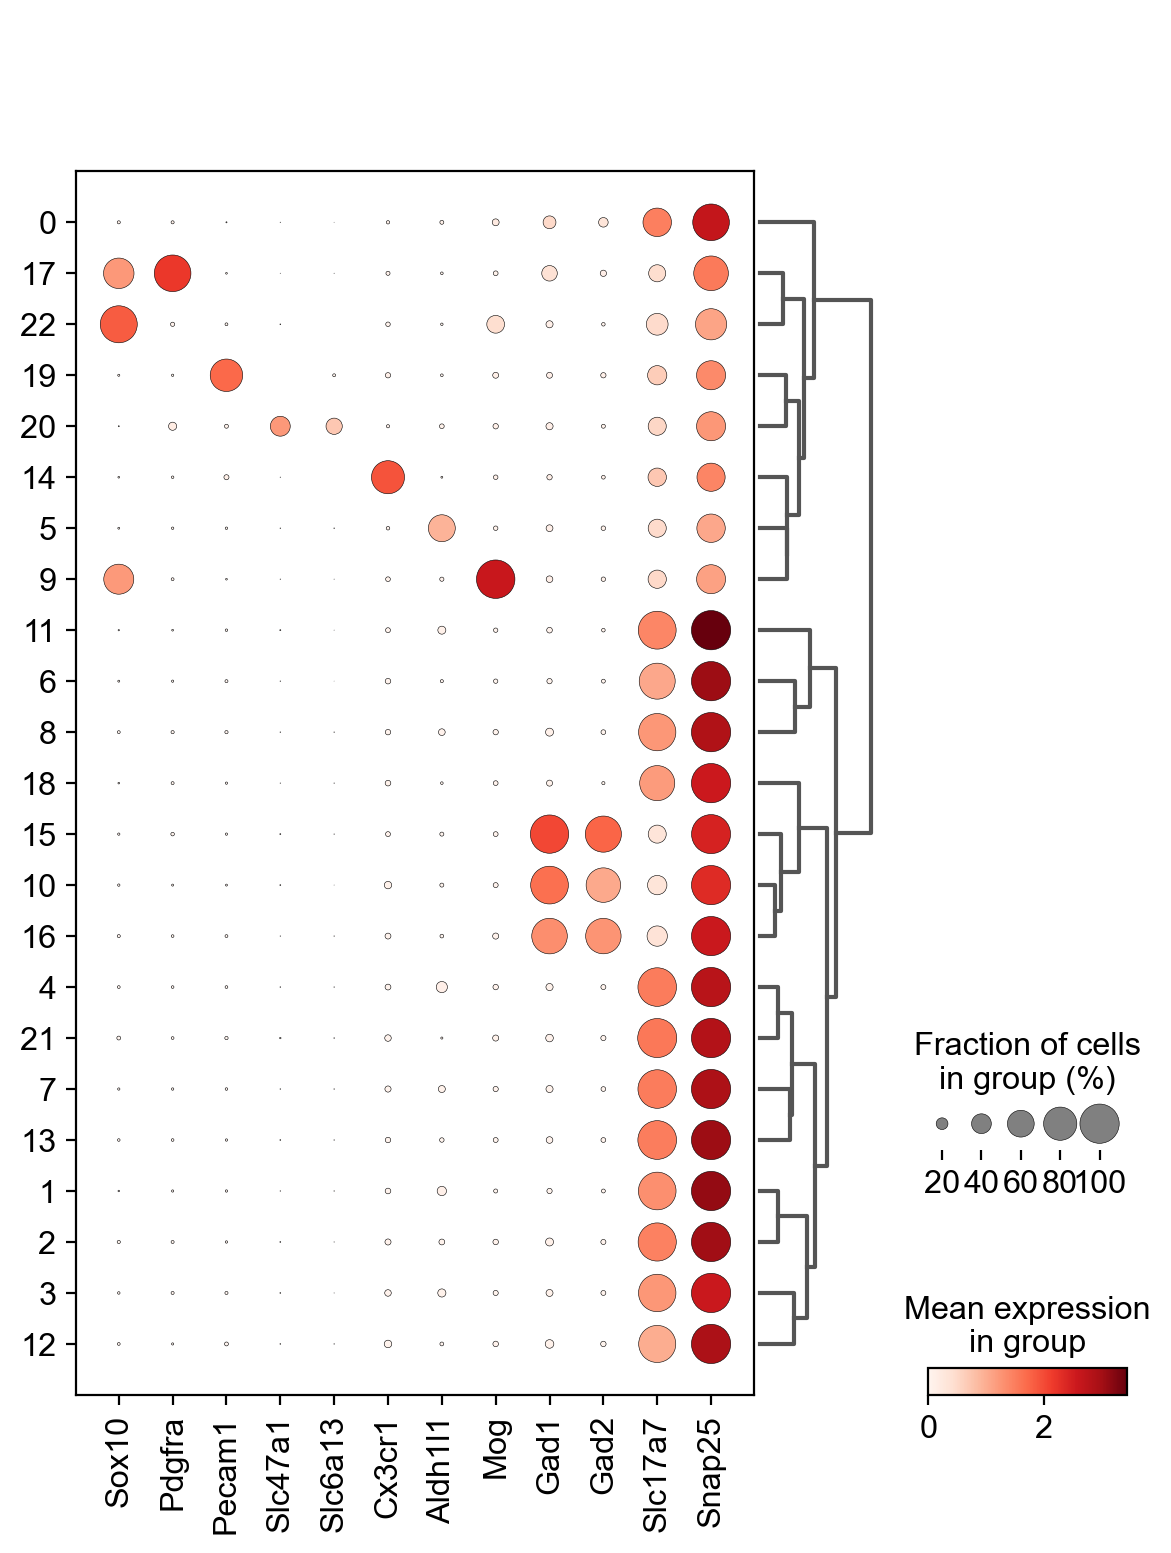

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<AxesSubplot:title={'center':'batch'}, xlabel='UMAP1', ylabel='UMAP2'>

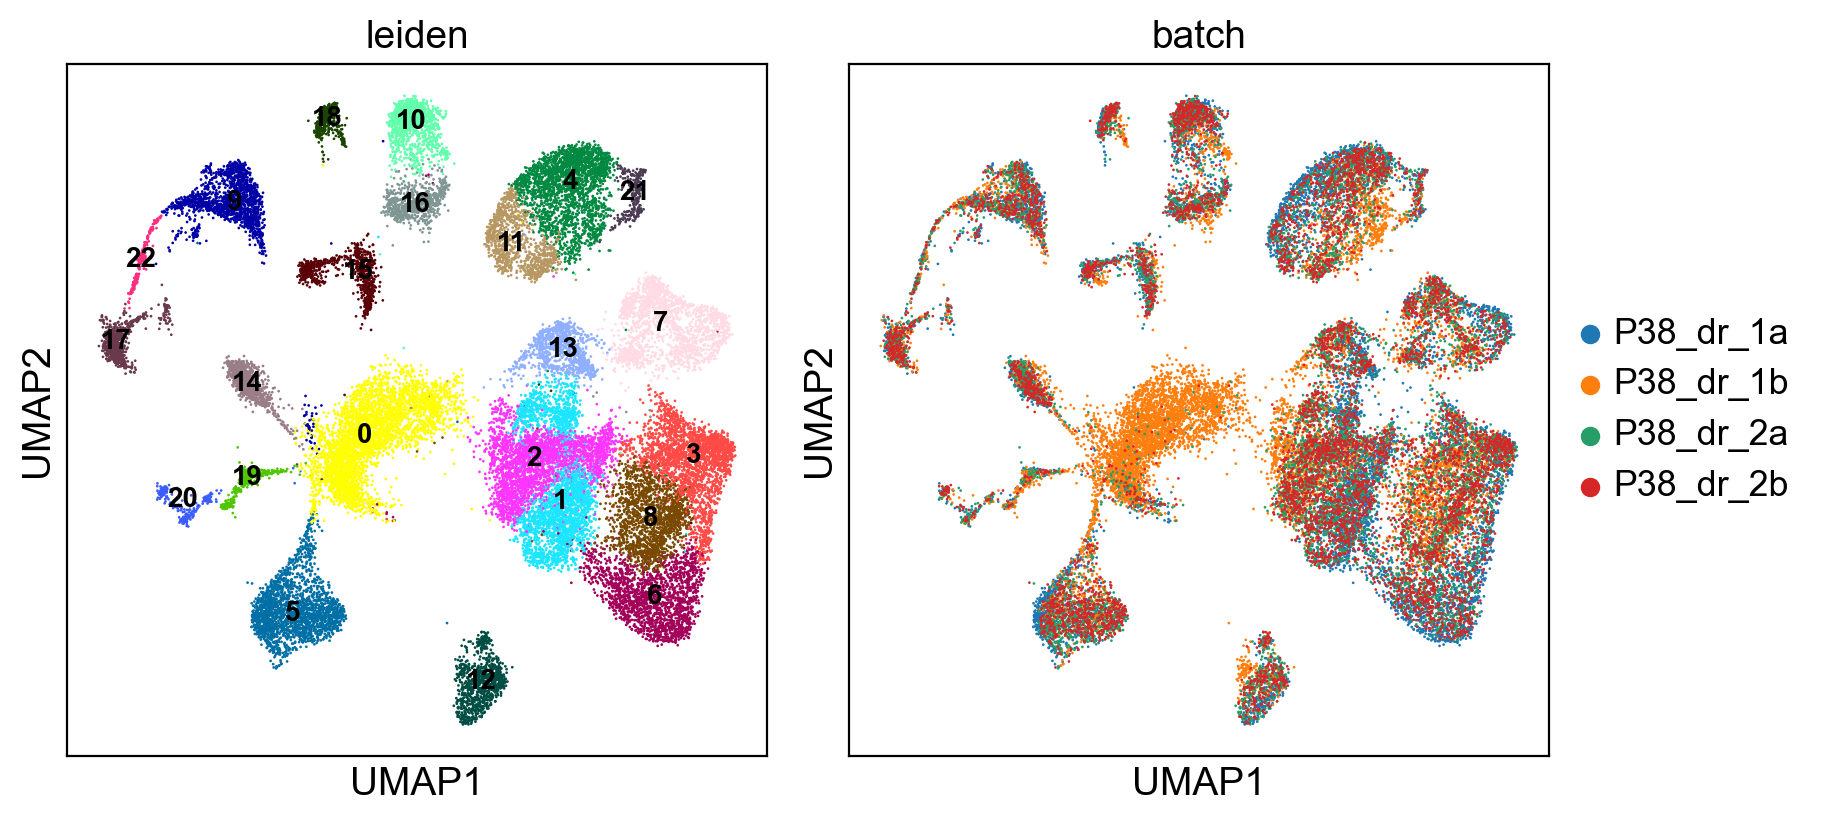

In [51]:
#w/bbknn
leiden_markers = ['Sox10', 'Pdgfra', 'Pecam1', 'Slc47a1', 'Slc6a13', 'Cx3cr1', 'Aldh1l1', 'Mog', 'Gad1', 'Gad2', 'Slc17a7', 'Snap25'] 
               
sc.tl.dendrogram(P28_dr, groupby='leiden')
sc.pl.dotplot(P28_dr, leiden_markers, groupby='leiden', dendrogram=True)


fig, axs = plt.subplots(1, 2, figsize = (9,4), constrained_layout=True)

sc.pl.umap(P28_dr, color=['leiden'], legend_fontsize='10', legend_loc='on data', ax=axs[0], show=False)
sc.pl.umap(P28_dr, color=['batch'], ax=axs[1], show=False)
#sc.pl.umap(P28_dr, color=['leiden', 'Doublet', 'batch', 'Snap25', 'Gad1', 'Gad2', 'Slc17a7'], legend_fontsize='10', legend_loc='on data')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


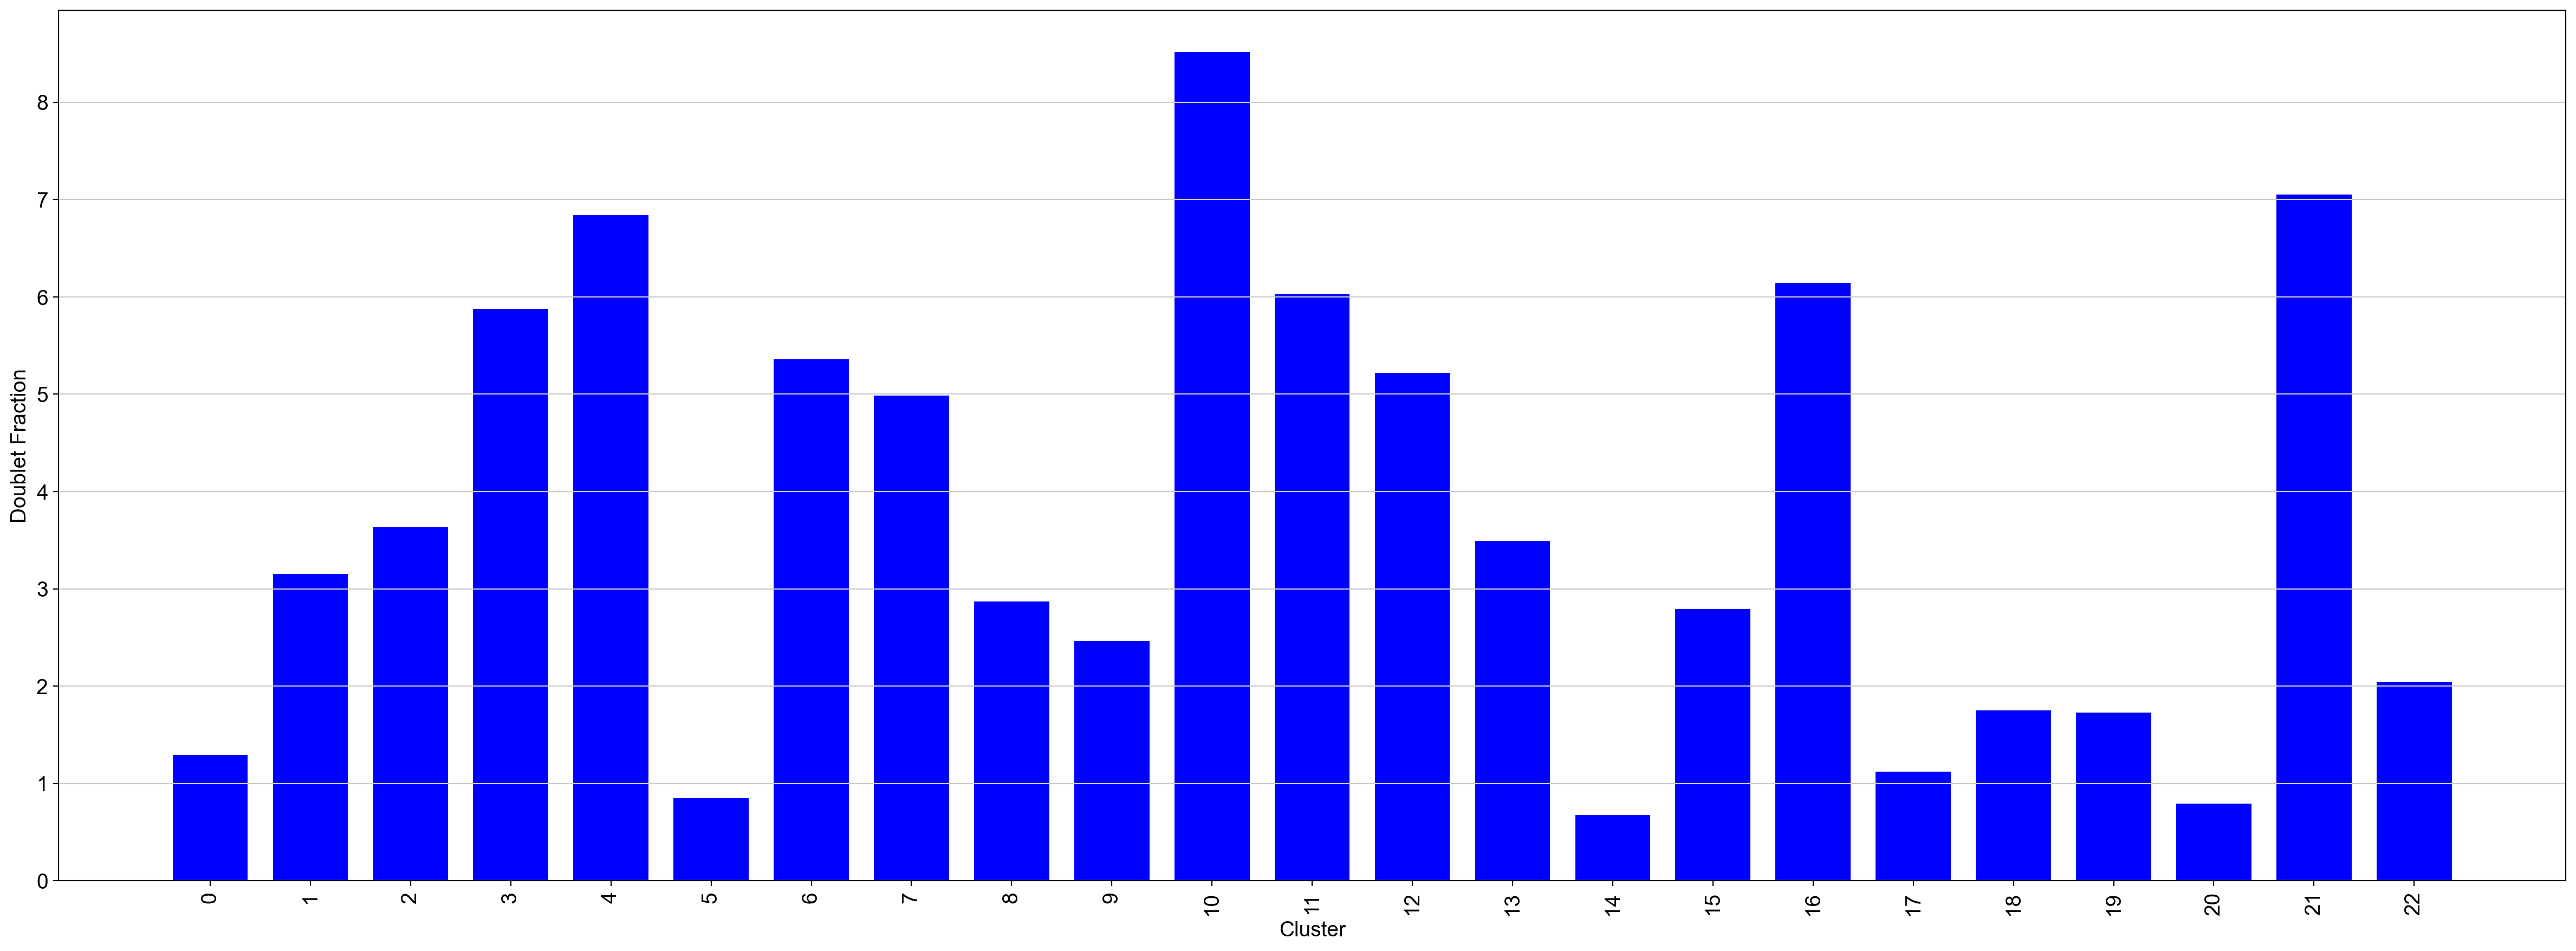

In [46]:
doublet_perc = []
x_pos = list(P28_dr.obs.leiden.values.categories)
for i in x_pos:
    current_clust = P28_dr[P28_dr.obs.leiden==i, :]
    doublet_perc.append((current_clust[current_clust.obs.Doublet,:].shape[0]/current_clust.shape[0])*100)

fig, ax = plt.subplots(figsize=(24,9))
ax.bar(x_pos, doublet_perc, color='blue', width=0.75)
ax.set_ylabel('Doublet Fraction')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos, rotation='90')
#ax.set_title('Percentage of doublets')
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.set_xlabel('Cluster')
# Save the figure and show
plt.tight_layout()

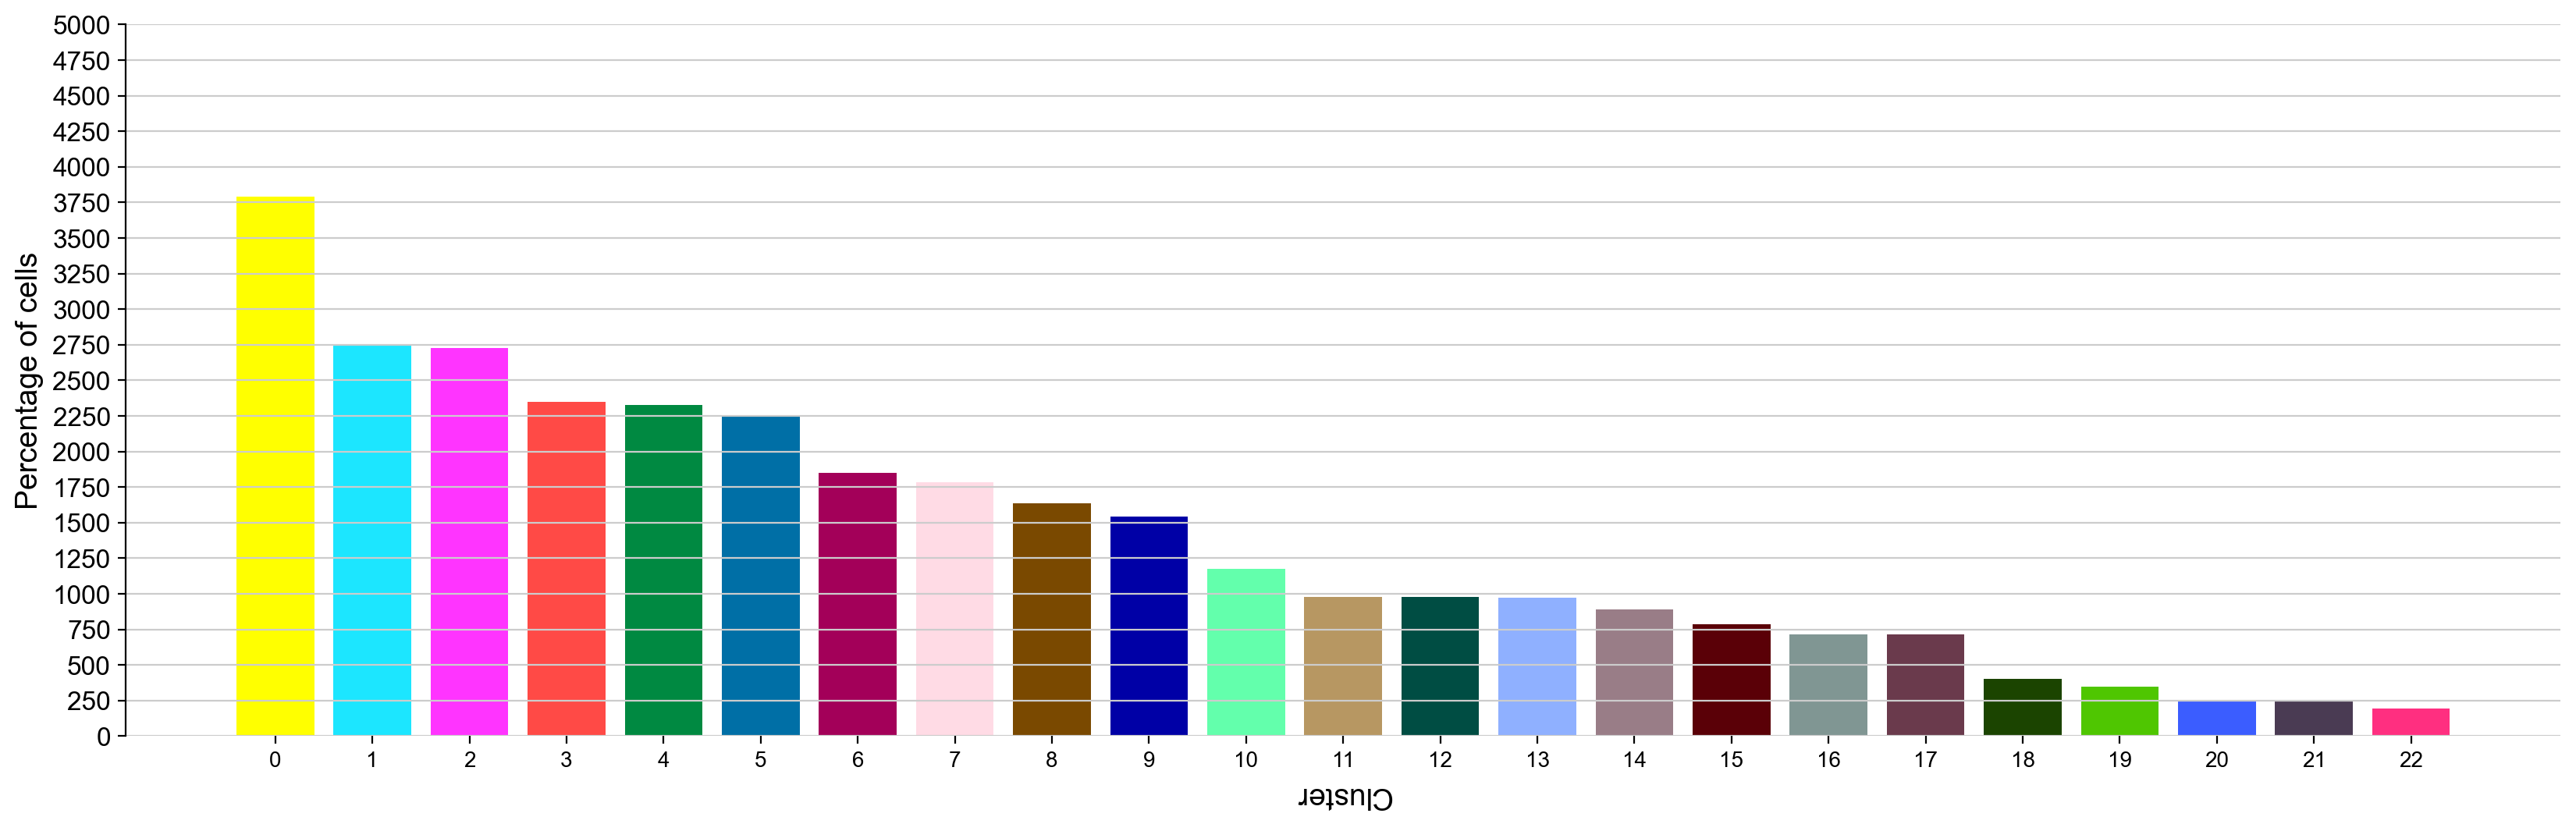

In [47]:
#code
x_pos = list(P28_dr.obs.leiden.values.categories)

total_cells = P28_dr.shape[0]
cell_fraction = []
cell_count = []

for i in x_pos:
    #cell_fraction.append(P28_dr[P28_dr.obs.leiden==i, :].shape[0]*100/total_cells)
    cell_fraction.append(P28_dr[P28_dr.obs.leiden==i, :].shape[0])
    cell_count.append(P28_dr[P28_dr.obs.leiden==i, :].shape[0])



fig, ax = plt.subplots(figsize=(20,6))

right_side = ax.spines["right"]
top = ax.spines["top"]
bottom = ax.spines["bottom"]

right_side.set_visible(False)
top.set_visible(False)
bottom.set_visible(False)


plt.bar(x_pos, cell_fraction, color = P28_dr.uns['leiden_colors'])
plt.grid(axis='x')
plt.xticks(rotation='0', fontsize='10')
plt.yticks(fontsize ='12')

plt.xlabel('Cluster', rotation='180')
plt.ylabel('Percentage of cells')

plt.yticks(np.linspace(0, 5000, 21))
plt.show()


Scanorama

In [55]:
#P28_dr = adata_gluta[adata_gluta.obs.batch=='P28', :] no need after first time
del P28_dr.obsp
del P28_dr.varm
del P28_dr.obsm
del P28_dr.uns
P28_dr.X = P28_dr.raw.X
sc.pp.highly_variable_genes(P28_dr, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs

'''
sc.pp.scale(P28_dr, max_value=10) #scale
sc.tl.pca(P28_dr, svd_solver='arpack') #run PCA

P28_dr_CBs = list(P28_dr.obs.index)
P28_dr_batch = []
for i in range(len(P28_dr_CBs)):
    P28_dr_batch.append(P28_dr_CBs[i][19:25])
    
P28_dr.obs['sample'] = P28_dr.obs['batch']
P28_dr.obs['sample'] = P28_dr_batch

#sc.pp.neighbors(P28_dr, n_neighbors=25, n_pcs=40) #choose 25 standard for now
bbknn(P28_dr, batch_key='sample',neighbors_within_batch=6 ) #8*3~=25
sc.tl.leiden(P28_dr)
sc.tl.umap(P28_dr)
'''

var_genes = list(P28_dr[:,P28_dr.var['highly_variable']].var_names)

batches = ['P38_dr_1a', 'P38_dr_1b', 'P38_dr_2a', 'P38_dr_2b']
alldata = {}
for batch in batches:
    alldata[batch] = P28_dr[P28_dr.obs['batch'] == batch,]

alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

#convert to list of AnnData objects
P28_drs = list(alldata2.values())

# run scanorama.integrate
scanorama  = scr.integrate_scanpy(P28_drs, dimred = 50,)

# returns a list of 2 np.ndarrays with 50 columns.

print(scanorama[0].shape)
print(scanorama[1].shape)

# make inteo one matrix.
all_s = np.concatenate(scanorama)
print(all_s.shape)

# add to the AnnData object
P28_dr.obsm["SC"] = all_s

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
P38_dr_1a
P38_dr_1b
P38_dr_2a
P38_dr_2b
Found 4191 genes among all datasets
[[0.         0.48989837 0.84865924 0.79123301]
 [0.         0.         0.67106927 0.53810307]
 [0.         0.         0.         0.94243421]
 [0.         0.         0.         0.        ]]
Processing datasets (2, 3)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (0, 1)
(8167, 50)
(9079, 50)
(31659, 50)


In [56]:
sc.pp.neighbors(P28_dr, n_neighbors=25, n_pcs=40, use_rep='SC')
sc.tl.leiden(P28_dr)
sc.tl.umap(P28_dr)

computing neighbors


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/ana

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
running Leiden clustering
    finished: found 31 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:27)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:30)


Storing dendrogram info using `.uns["dendrogram_['leiden']"]`


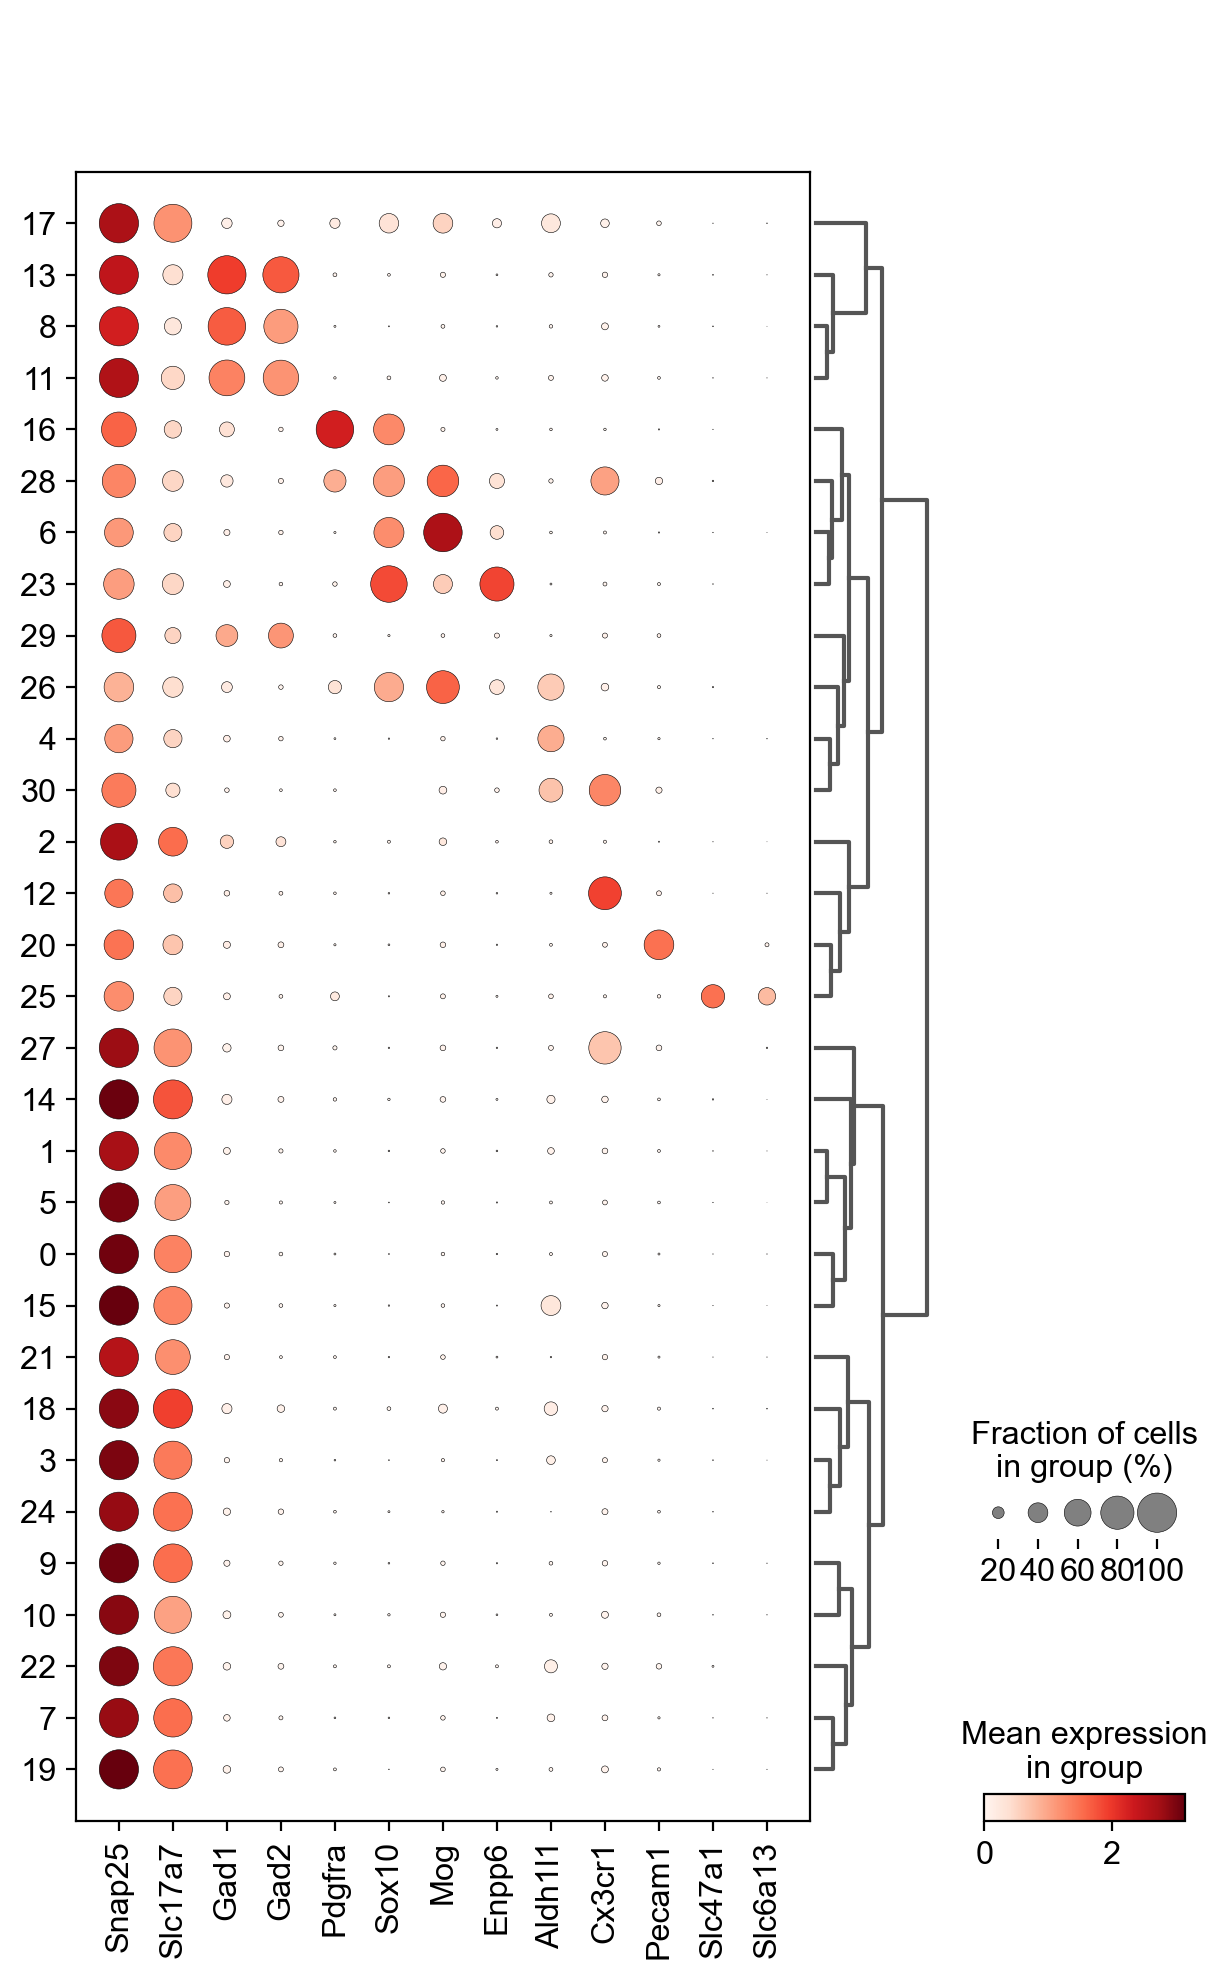

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<AxesSubplot:title={'center':'batch'}, xlabel='UMAP1', ylabel='UMAP2'>

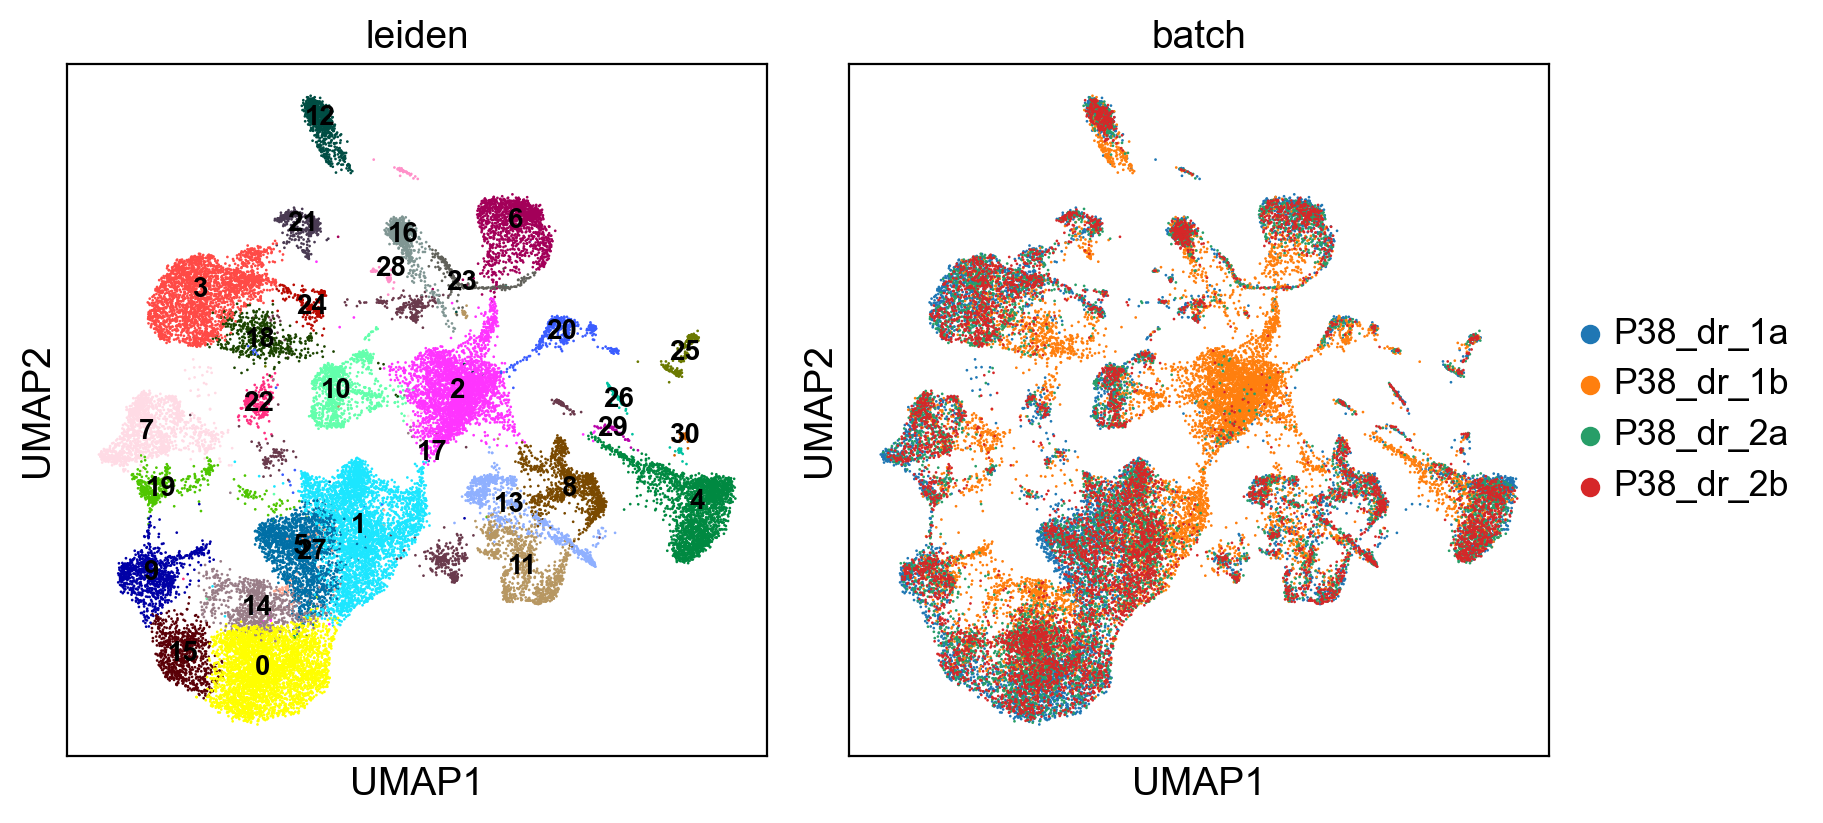

In [60]:
#w/scanorama b/c of reservations about gad1/2 expression in C0/4


leiden_markers = ['Snap25', 'Slc17a7', 'Gad1', 'Gad2', 'Pdgfra', 'Sox10', 'Mog', 'Enpp6', 'Aldh1l1',  'Cx3cr1', 'Pecam1', 'Slc47a1', 'Slc6a13',]

sc.tl.dendrogram(P28_dr, groupby='leiden', use_rep='SC')

sc.pl.dotplot(P28_dr, leiden_markers, groupby='leiden', dendrogram=True)



fig, axs = plt.subplots(1, 2, figsize = (9,4), constrained_layout=True)

sc.pl.umap(P28_dr, color=['leiden'], legend_fontsize='10', legend_loc='on data', ax=axs[0], show=False)
sc.pl.umap(P28_dr, color=['batch'], ax=axs[1], show=False)

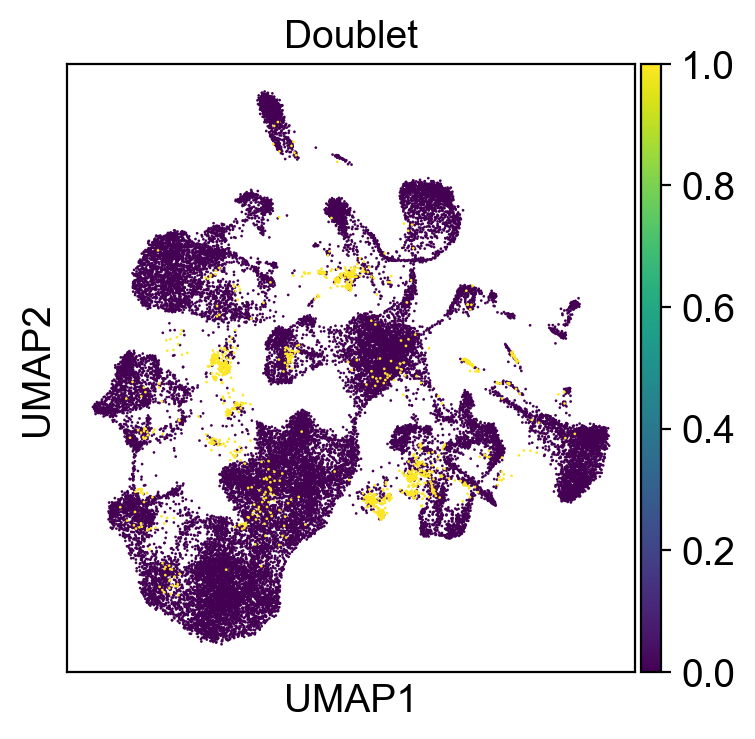

In [61]:
sc.pl.umap(P28_dr, color=['Doublet'])

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


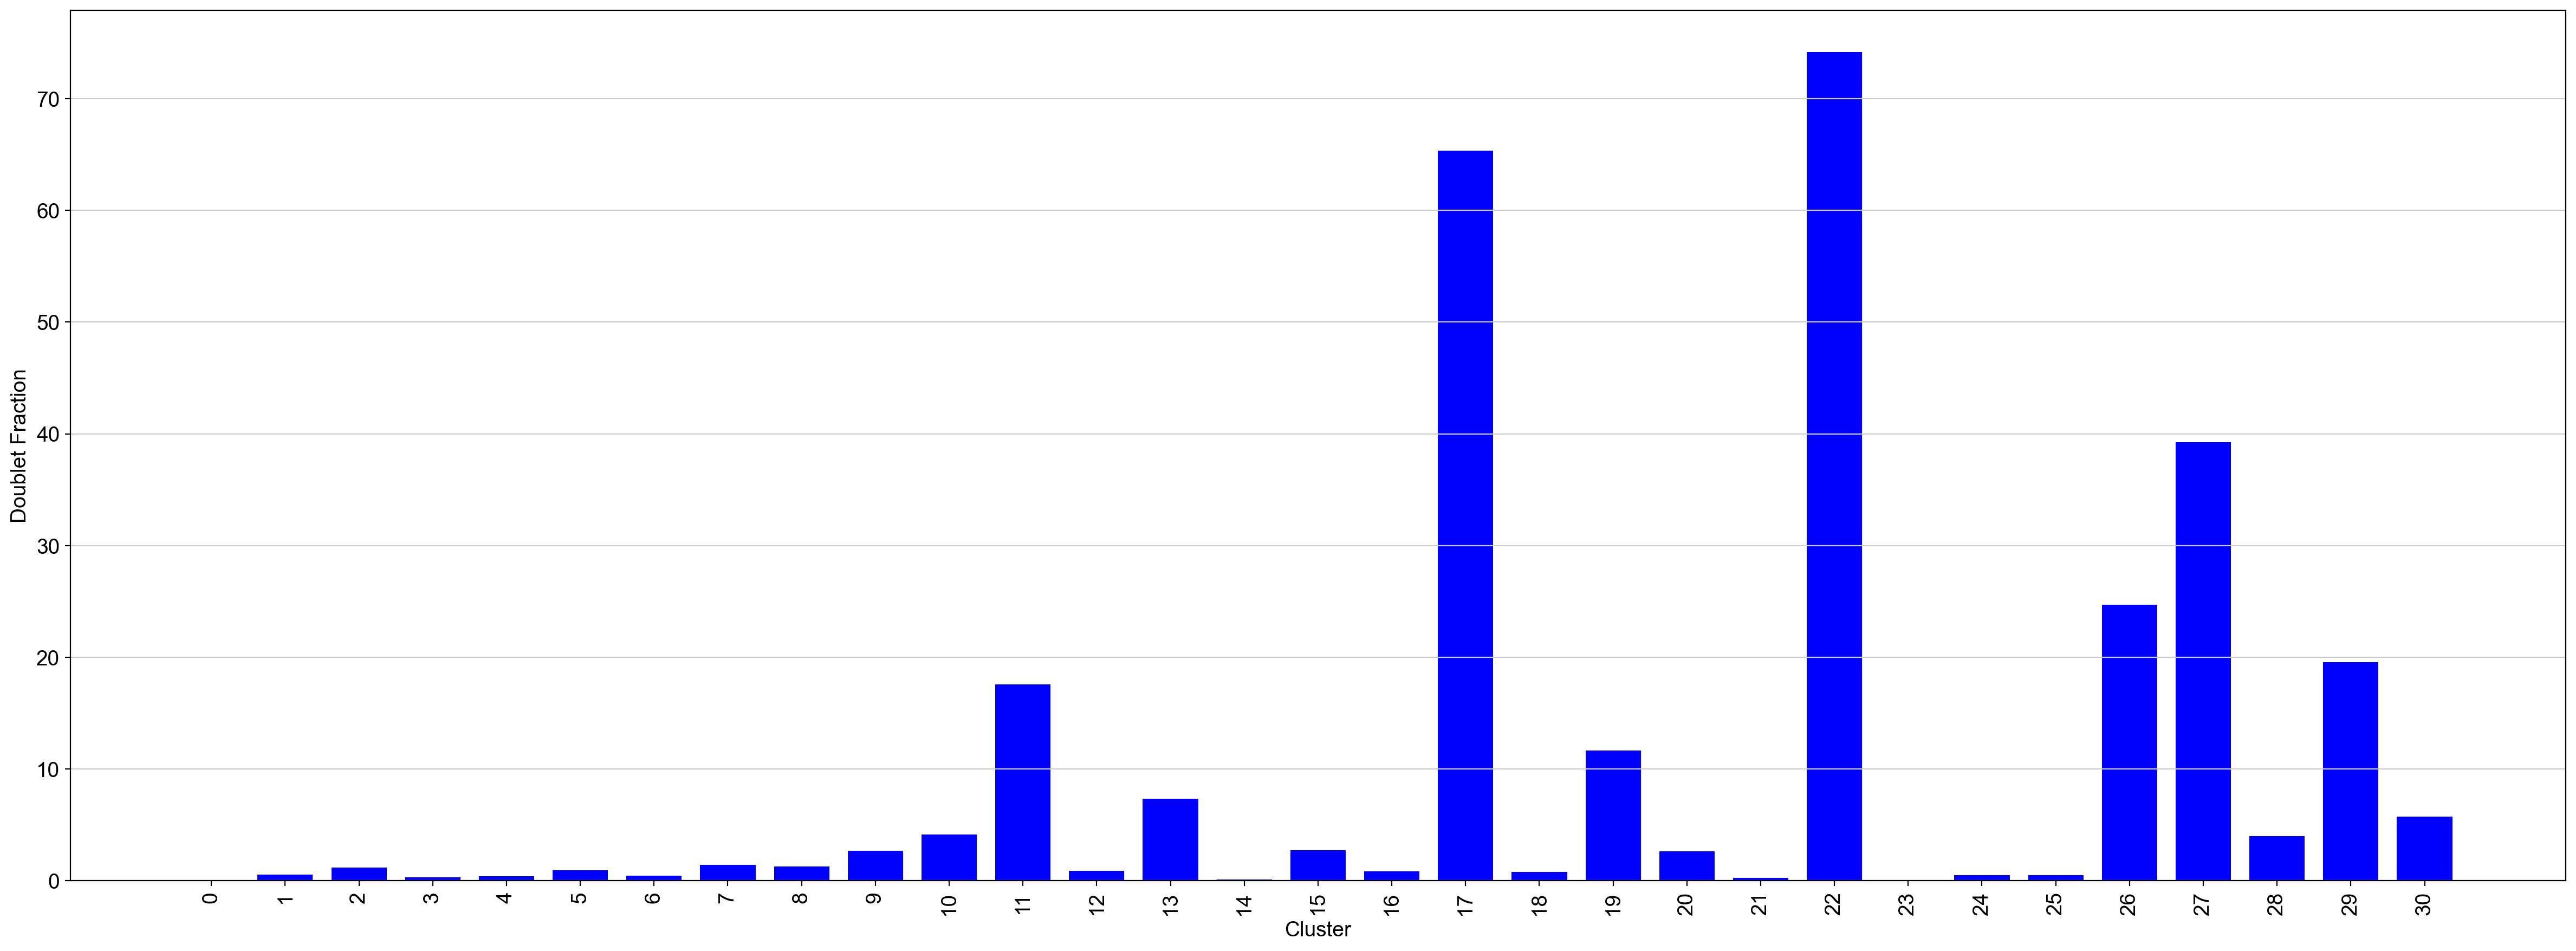

In [62]:
doublet_perc = []
x_pos = list(P28_dr.obs.leiden.values.categories)
for i in x_pos:
    current_clust = P28_dr[P28_dr.obs.leiden==i, :]
    doublet_perc.append((current_clust[current_clust.obs.Doublet,:].shape[0]/current_clust.shape[0])*100)

fig, ax = plt.subplots(figsize=(24,9))
ax.bar(x_pos, doublet_perc, color='blue', width=0.75)
ax.set_ylabel('Doublet Fraction')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos, rotation='90')
#ax.set_title('Percentage of doublets')
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.set_xlabel('Cluster')
# Save the figure and show
plt.tight_layout()

In [24]:
#amount of gaba cells aligns well with NR
P28_dr[P28_dr.obs.leiden=='15',:].shape[0] + P28_dr[P28_dr.obs.leiden=='10',:].shape[0] + P28_dr[P28_dr.obs.leiden=='16',:].shape[0]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


2678

## Remove doublets and export 3 objs
Use BBKNN'd object

In [25]:
P28_dr

AnnData object with n_obs × n_vars = 31659 × 20354
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells-P38_dr_1a', 'n_cells-P38_dr_1b', 'n_cells-P38_dr_2a', 'n_cells-P38_dr_2b', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', "dendrogram_['leiden']"
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden']"]`


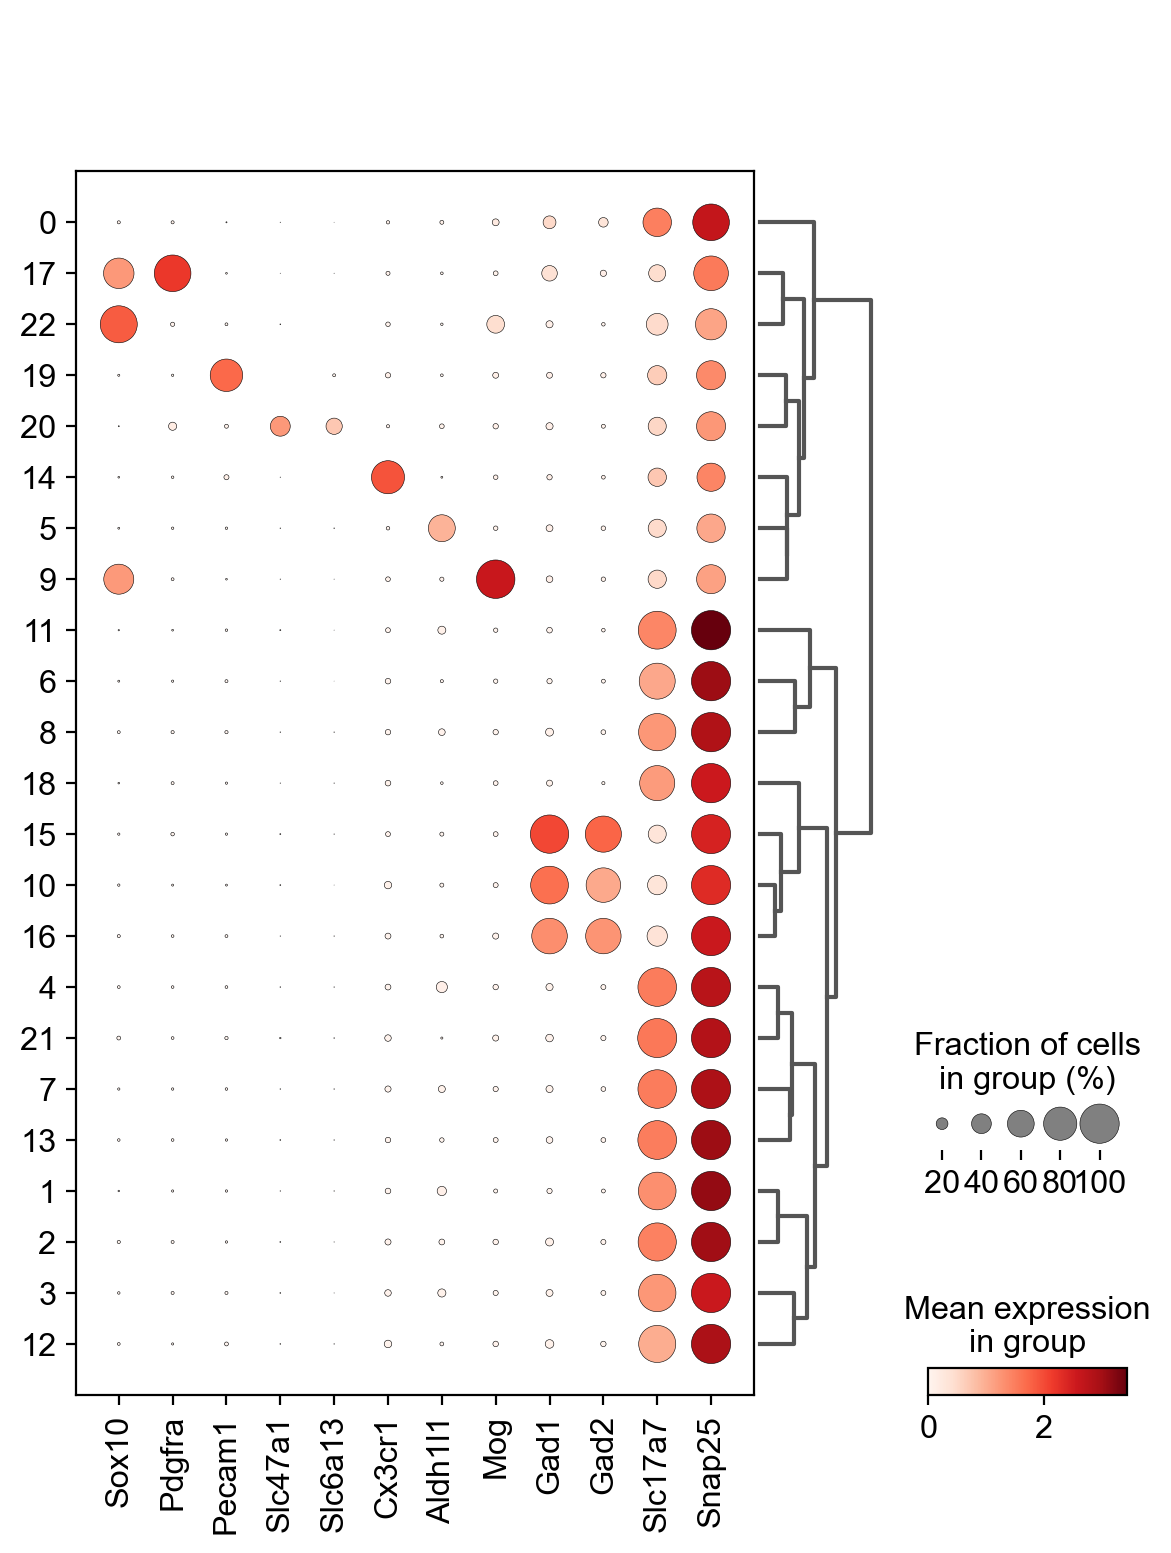

In [23]:
leiden_markers = ['Sox10', 'Pdgfra', 'Pecam1', 'Slc47a1', 'Slc6a13', 'Cx3cr1', 'Aldh1l1', 'Mog', 'Gad1', 'Gad2', 'Slc17a7', 'Snap25'] 

sc.pl.dotplot(P28_dr, leiden_markers, groupby='leiden', dendrogram=True)

In [26]:
P28_dr_dub = P28_dr[P28_dr.obs.Doublet==False,:]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [27]:
P28_dr_dub.obs['sample'] = P28_dr_dub.obs['batch']

Trying to set attribute `.obs` of view, copying.


In [28]:
P28_dr_dub

AnnData object with n_obs × n_vars = 30475 × 20354
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample'
    var: 'gene_ids', 'feature_types', 'n_cells-P38_dr_1a', 'n_cells-P38_dr_1b', 'n_cells-P38_dr_2a', 'n_cells-P38_dr_2b', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', "dendrogram_['leiden']"
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### GABAergic

In [29]:
P28_gaba = P28_dr_dub[P28_dr_dub.obs.leiden=='15',:].concatenate(P28_dr_dub[P28_dr_dub.obs.leiden=='10',:],
                                                                 P28_dr_dub[P28_dr_dub.obs.leiden=='16',:])

In [31]:
P28_gaba.write_h5ad(export_path + 'P38_dr_gaba.h5ad')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'leiden' as categorical


In [4]:
P38_gaba = sc.read_h5ad(export_path + 'P38_dr_gaba.h5ad')
P38_glut = sc.read_h5ad(export_path + 'P38_dr_glut.h5ad')
P38_non = sc.read_h5ad(export_path + 'P38_dr_non.h5ad')

In [5]:
P38_gaba.shape[0] + P38_glut.shape[0] + P38_non.shape[0]

30475

In [7]:
P38_glut.shape[0]

21855

### Glutamatergic

In [32]:
P28_glut = P28_dr_dub[P28_dr_dub.obs.leiden=='0',:].concatenate(P28_dr_dub[P28_dr_dub.obs.leiden=='11',:],
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='6',:],
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='8',:],
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='18',:],
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='4',:],
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='21',:],
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='7',:],
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='13',:],
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='1',:],
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='2',:],
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='3',:],
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='12',:])

In [33]:
P28_glut.write_h5ad(export_path + 'P38_dr_glut.h5ad')

... storing 'leiden' as categorical


### Non-neurons

In [34]:
P28_non = P28_dr_dub[P28_dr_dub.obs.leiden=='17',:].concatenate(P28_dr_dub[P28_dr_dub.obs.leiden=='22',:],
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='19',:],
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='20',:],
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='14',:],
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='5',:], 
                                                                P28_dr_dub[P28_dr_dub.obs.leiden=='9',:])

In [35]:
P28_non.write_h5ad(export_path + 'P38_dr_non.h5ad')

... storing 'leiden' as categorical


In [36]:
#all cells exported
P28_non.shape[0] + P28_gaba.shape[0] + P28_glut.shape[0] == P28_dr_dub.shape[0]

True

# Read and check

In [9]:
def DE(adata, obs_id, obs_id_test, ref, n_genes):

    sc.tl.rank_genes_groups(adata, groupby=obs_id, groups=[obs_id_test], 
                            reference=ref, method='wilcoxon', n_genes=n_genes)

    wilcLF = adata.uns['rank_genes_groups']['logfoldchanges'].astype([(obs_id_test, '<f8')]).view('<f8') #log fold changes ordered by score

    wilcGenes_s = list(adata.uns['rank_genes_groups']['names'].astype([(obs_id_test, '<U50')]).view('<U50'))  #list of genes ordered by wilc score
    wilcLF_s = adata.uns['rank_genes_groups']['logfoldchanges'].astype([(obs_id_test, '<f8')]).view('<f8') #numpy array of logfoldchnages to be ordered lowest to highest
    wilcLF_s.sort() #log fold changes from lowest to highest
    wilcGenes = [] #list of genes ordered by logfold change: low to high

    for i in wilcLF_s:
        gene_idx = np.where(wilcLF == i)[0][0]
        wilcGenes.append(wilcGenes_s[gene_idx])

    wilcGenes_correct = []
    for i in reversed(wilcGenes):
        wilcGenes_correct.append(i) # #list of genes ordered by logfold change high to low
        
    return wilcGenes_correct
    

In [11]:
P38 = sc.read_h5ad('P38_dr_glut.h5ad')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


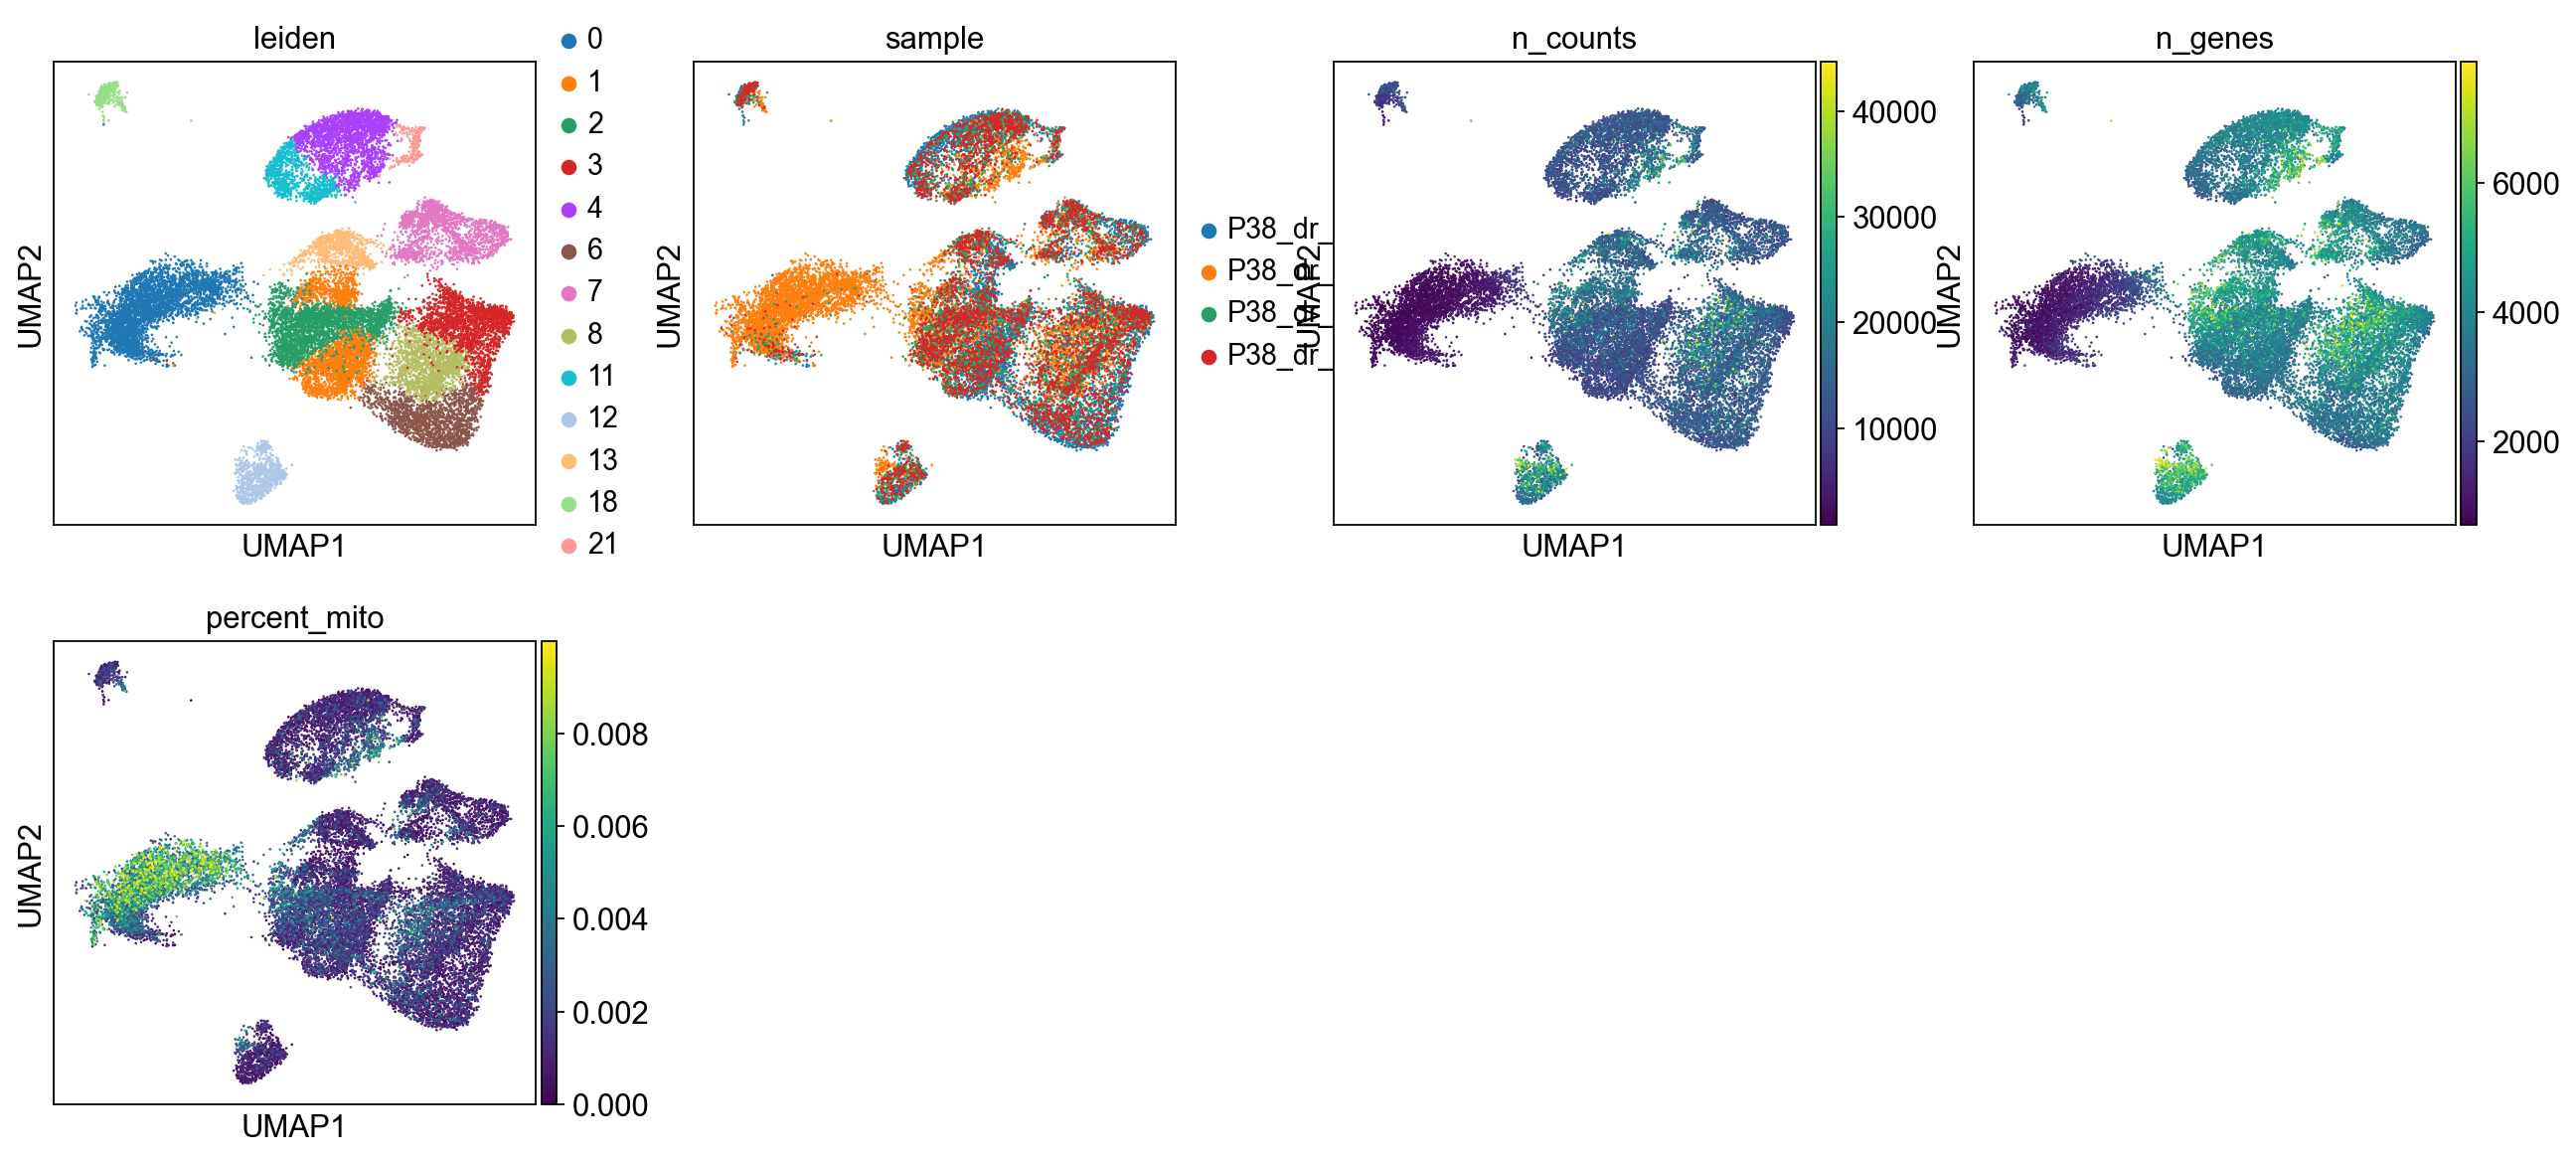

In [13]:
sc.set_figure_params()
sc.pl.umap(P38, color=['leiden', 'sample', 'n_counts', 'n_genes', 'percent_mito'])

In [14]:
de_genes = DE(P38, obs_id='leiden', obs_id_test='0', ref='rest', n_genes=50)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:34)


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


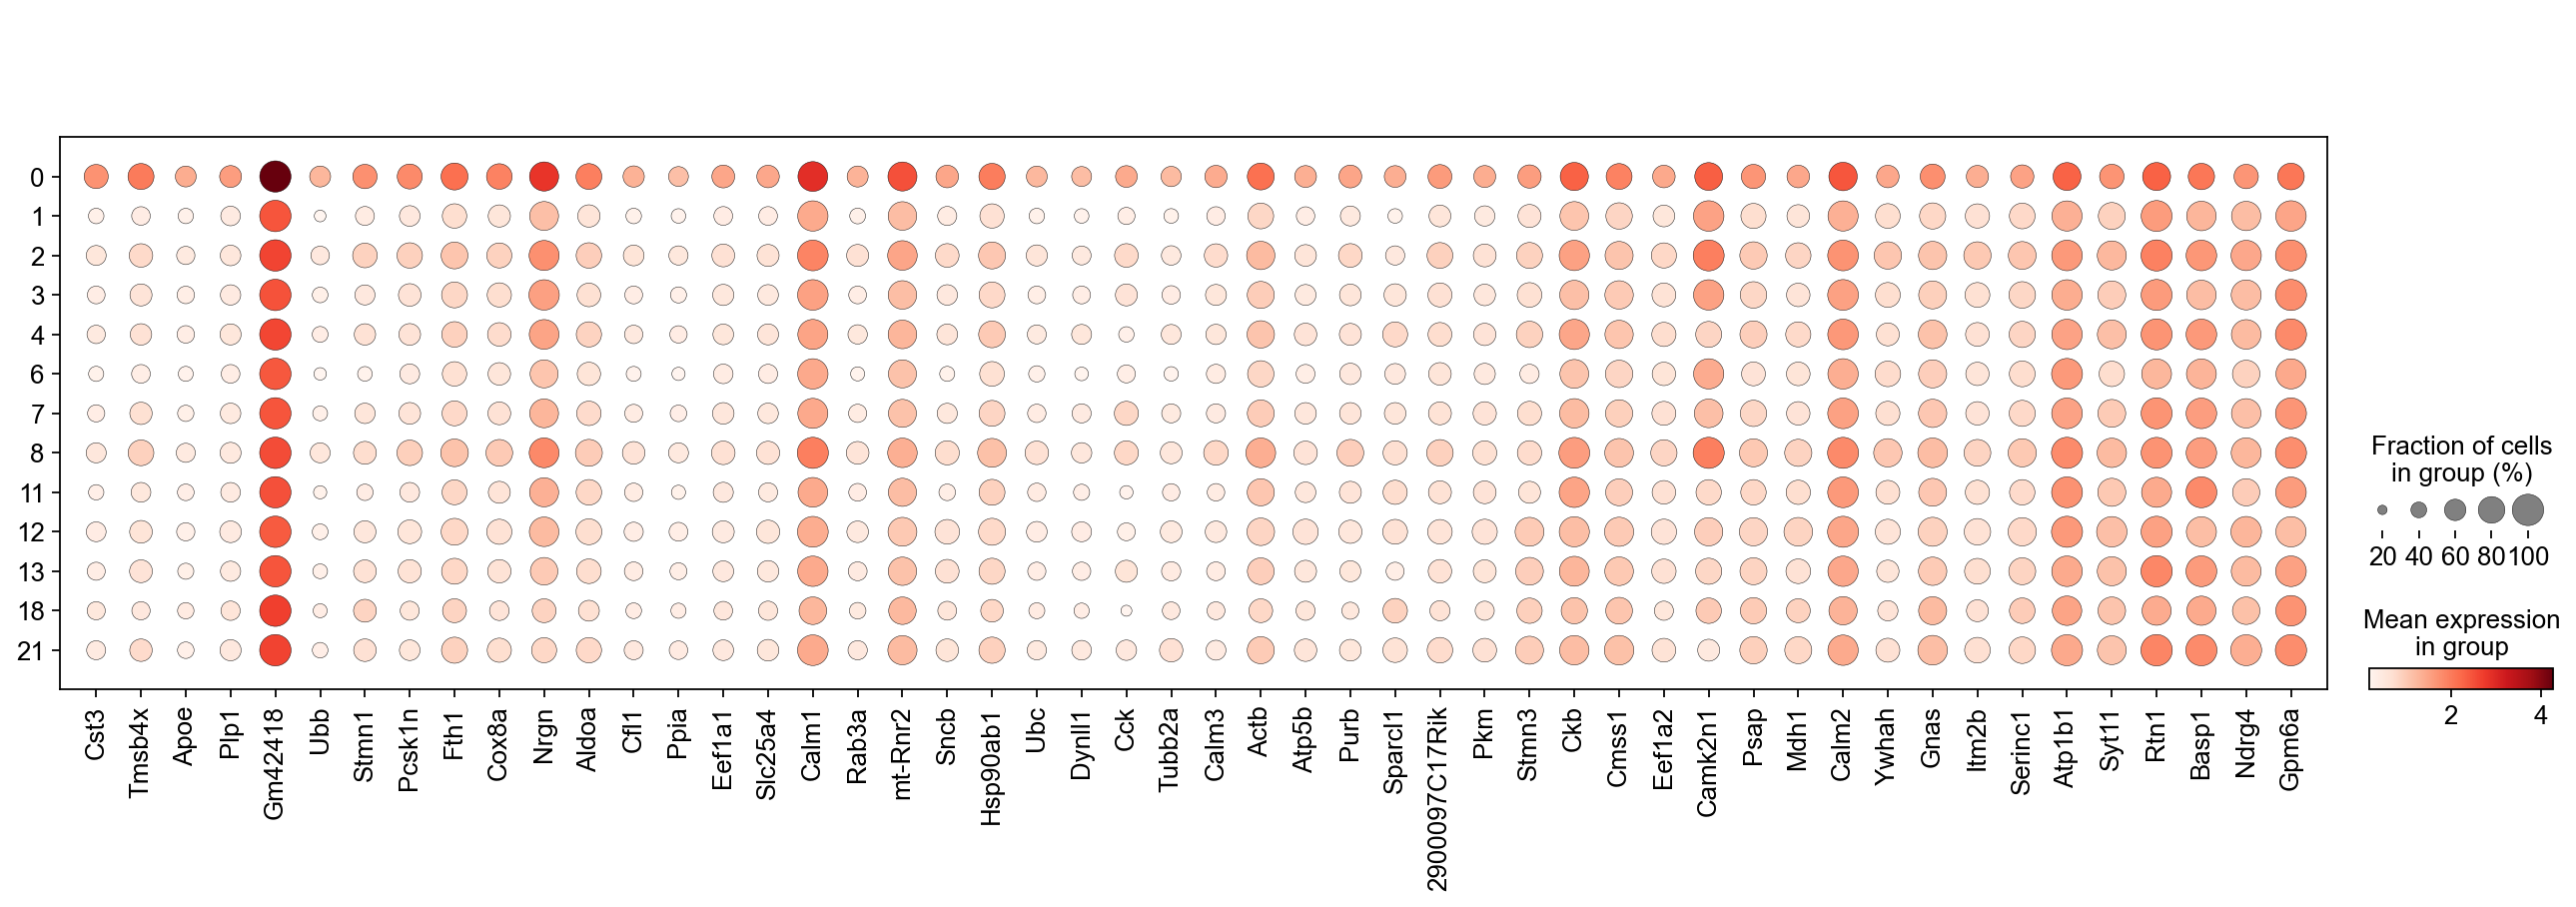

In [15]:
sc.pl.dotplot(P38, de_genes, groupby='leiden')

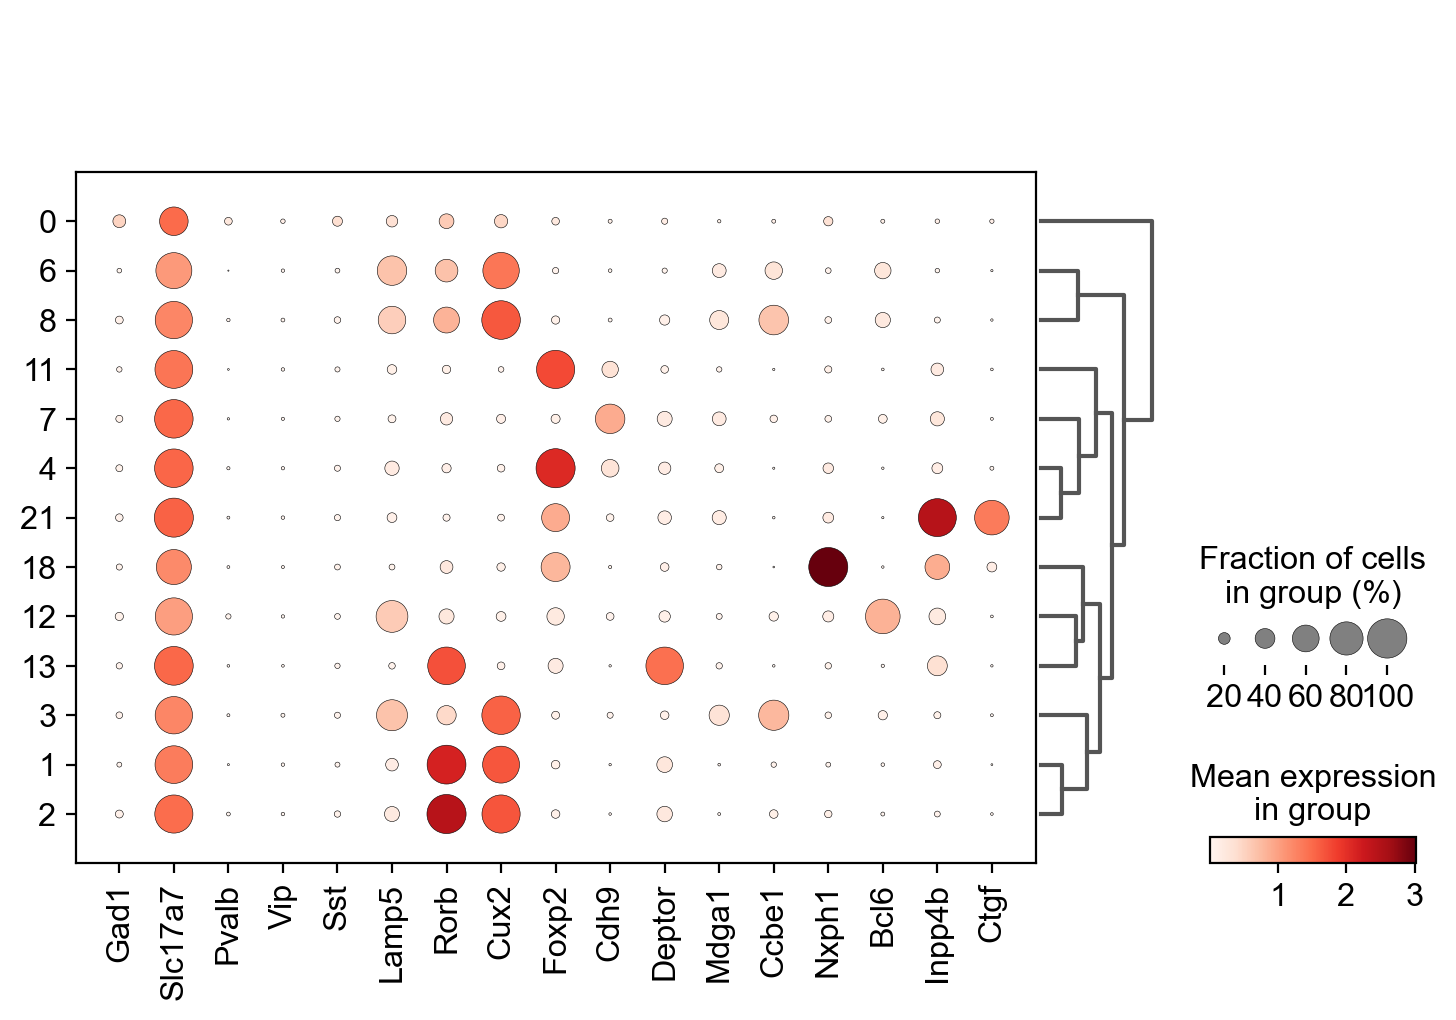

In [11]:
sc.pl.dotplot(P38, ['Gad1','Slc17a7','Pvalb', 'Vip', 'Sst', 'Lamp5', 'Rorb', 'Cux2', 'Foxp2', 'Cdh9', 'Deptor',  'Mdga1', 'Ccbe1', 'Nxph1', 'Bcl6',
                 'Inpp4b', 'Ctgf'], groupby='leiden', dendrogram=True)